# NeedleMaster Dataset Example

Predict the needle position and orientation from an image

## Imports 
* pytorch_datasets for Dataset class, DataLoader
* tdqm for interactive loading bars 
* numpy for math 
* torch for deep learning library
* torchvision for deep learning vision library 
* multiprocessing to run on multiple cpus (if applicable)
* random to select random trials/frames in _get__item_, and to make random datasplits
* matplotlib for displaying image frames
* pdb (debugging)

In [26]:
import sys
sys.path.insert(0, '/home/molly/workspace/Utils/pytorch_datasets/')

import random 
import numpy as np
from tqdm import tqdm as tdqm
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib import patches
from pdb import set_trace as woah

import torch
import torchvision
import pytorch_datasets

Code to set up the environment. Choose if the deep learning will run on the CPU or GPU. Initialize the torch random seed, and if using a GPU the GPU random seed. 

In [13]:
torch.manual_seed(random.randint(1, 10000))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(DEVICE == "cuda"):
    torch.cuda.manual_seed(random.randint(1, 10000))
    # Disable nondeterministic ops (not sure if critical but better safe than sorry)
    torch.backends.cudnn.enabled = False  

## Introduction
This notebook is an example for using the Pytorch Datasets wrapper to write a data loader for the NeedleMaster dataset. 

* __NeedleMaster__ is an Android game developped by Chris Paxton (https://github.com/cpaxton/needle_master_tools.) Images from recorded demonstrations were rendered to create a toy dataset with images, needle poses, and user actions. This dataset is currently on a local directory. For information contact molly@jhu.edu. 


## Loading Data 

In [3]:
nm = pytorch_datasets.NeedleMaster('/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/', \
                                   train_split=None, transforms=None)

The attribute '_getitem_' can be used to load individual images and needle poses. The needle position is x/screen_width, y/screen_width, and theta/2_pi

<IPython.core.display.Javascript object>


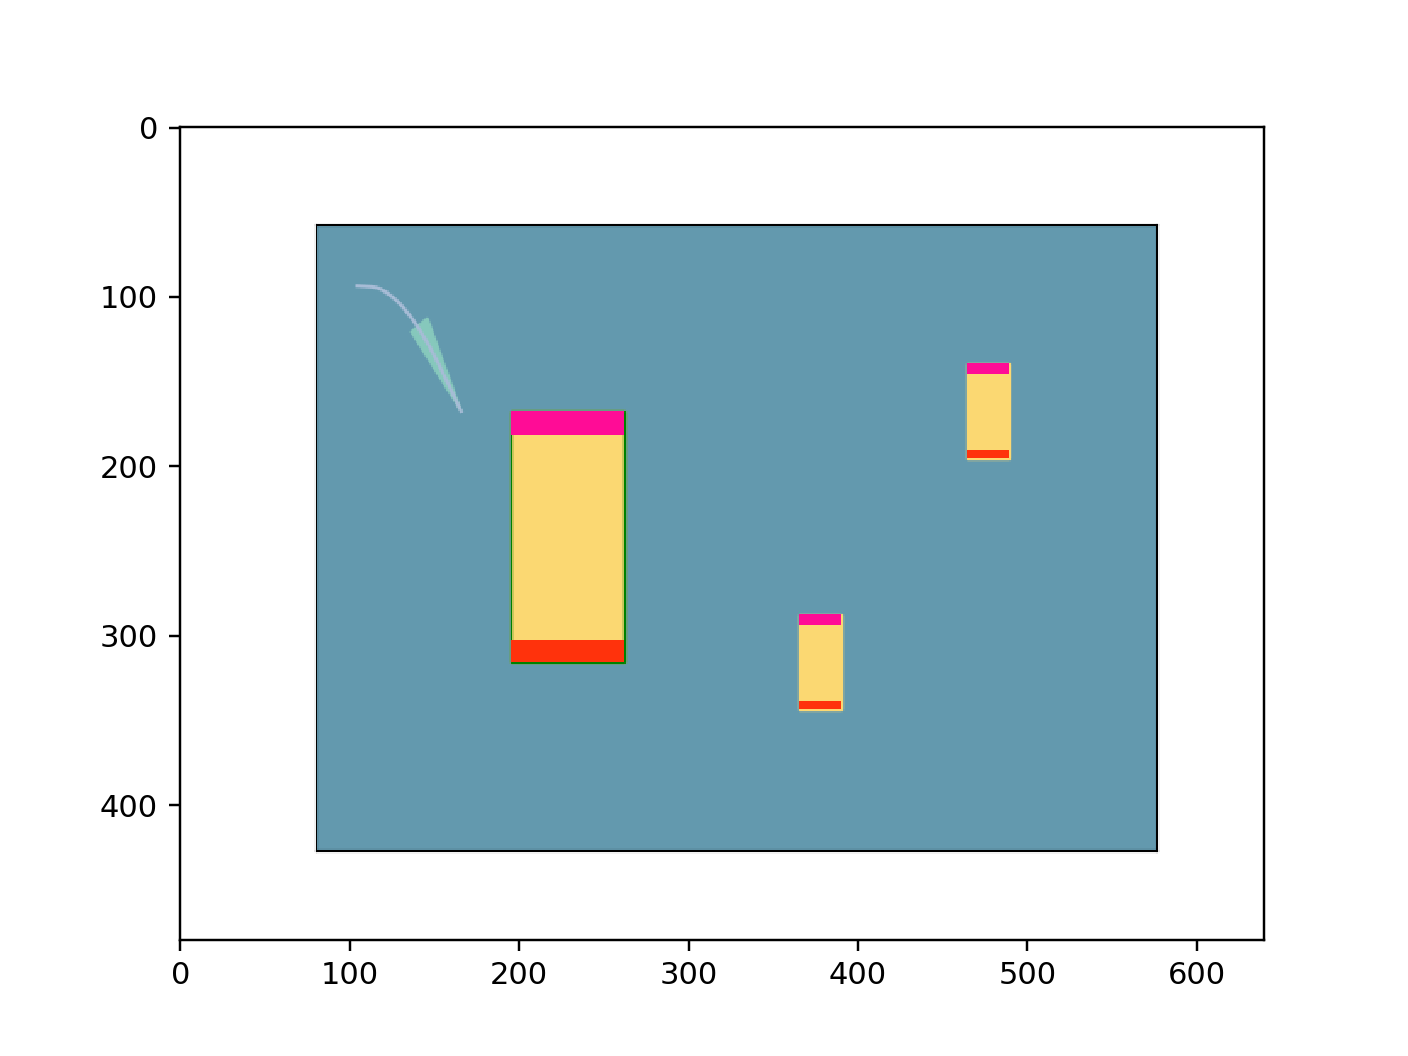

needle pose: [ 0.17348039  0.29952602  0.6588257 ]


In [14]:
% matplotlib notebook
sample = nm.__getitem__()#idx=100, frame_idx=10)

plt.imshow(sample['image'])
#plt.scatter(sample['needle'][0]*500 + 80, sample['needle'][1]*370 + 60, c='r')
plt.show()

print('needle pose: ' + str(sample['needle']))

In [5]:
transform = torchvision.transforms.Compose([
    #torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomCrop((224, 224)),
#     torchvision.transforms.RandomRotation(30),
#     torchvision.transforms.ColorJitter(.2, .2, .2, .2), 
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

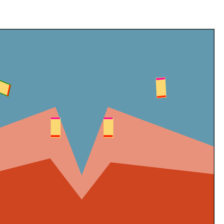

In [6]:
toPIL = torchvision.transforms.ToPILImage()
transform(toPIL(sample['image']))

In [7]:
def tensor_to_numpy_im(image):
    C, W, H = image.size()
    numpy_image = np.zeros((W, H, C))
    for c in range(C):
        numpy_image[:,:,c] = image[c,:,:].numpy()
    return numpy_image

## Model 
A pretrained resnet18 model is used with a final fully connected layer. The FC layer is used to regress the pose of the needle.

In [8]:
class resnet18(torch.nn.Module):
    """ Example Model. ResNet18 with a regression layer on top. """
    def __init__(self, num_labels):
        super(Model, self).__init__()
        self.base_model = torch.nn.Sequential(*list(torchvision.models.resnet18(pretrained=True).children())[:-1])
        base_model_fc_size = list(self.base_model.parameters())[-1].size(0)
        self.fc = torch.nn.Linear(base_model_fc_size, num_labels)
        self.sm = torch.nn.Softmax()
        
    def forward(self, images):
        im_features = self.base_model(images)
        preds = self.fc(im_features.squeeze())
        return preds

In [9]:
class cnn3(torch.nn.Module):
    """ small network trained from scratch"""
    def __init__(self, side_len, num_labels):
        super(cnn4, self).__init__()
        # convolutional layers 
        self.conv1 = torch.nn.Conv2d(3,   5, 5, stride=2, padding=True)
        self.conv2 = torch.nn.Conv2d(5,  10, 5, stride=4, padding=True)
        self.conv3 = torch.nn.Conv2d(10, 20, 5, stride=4, padding=True)
        self.relu  = torch.nn.ReLU()
        
        self.fc1 = torch.nn.Linear(980, 50)
        self.fc2 = torch.nn.Linear(50,  num_labels)
        self.sm  = torch.nn.Softmax()
        
    def forward(self, images):
        im_size = images.size()
        h1 = self.relu(self.conv1(images))
        h2 = self.relu(self.conv2(h1))
        h3 = self.relu(self.conv3(h2))
        
        preds = self.fc2(self.fc1(h3.view(im_size[0], -1).squeeze()))
        return preds

In [10]:
class cnn5(torch.nn.Module):
    """ small network trained from scratch"""
    def __init__(self, side_len, n_classes, num_labels, mode='regress'):
        super(cnn5, self).__init__()
        # convolutional layers 
        self.conv1 = torch.nn.Conv2d(3,   5, 5, padding=True)
        self.conv2 = torch.nn.Conv2d(5,  10, 5, padding=True)
        self.conv3 = torch.nn.Conv2d(10, 20, 5, padding=True)
        self.conv4 = torch.nn.Conv2d(20, 30, 5, padding=True)
        self.conv5 = torch.nn.Conv2d(30, 40, 5, padding=True)
        self.pool  = torch.nn.AvgPool2d(2, stride=2)
        self.relu  = torch.nn.ReLU()
        
        self.mode = mode
        
        if(mode == 'classify'):
            self.fc1  = torch.nn.Linear(360, n_classes)
        elif(mode == 'regress'):
            self.fc1  = torch.nn.Linear(360, num_labels)
            
        #self.fc2 = torch.nn.Linear(100,  num_labels)
        self.sm   = torch.nn.Softmax()
        
        
    def forward(self, images):
        im_size = images.size()

        h1 = self.relu(self.pool(self.conv1(images)))
        h2 = self.relu(self.pool(self.conv2(h1)))
        h3 = self.relu(self.pool(self.conv3(h2)))
        h4 = self.relu(self.pool(self.conv4(h3)))
        h5 = self.relu(self.pool(self.conv5(h4)))
        
        if(self.mode == 'classify'):
            preds = self.fc1(h5.view(im_size[0] , -1).squeeze())
            
        elif(self.mode == 'regress'):
            preds = self.fc1(h5.view(im_size[0], -1).squeeze()) #OPT: add softmax 
            #preds = self.fc2(self.fc1(h5.view(im_size[0], n_classes, -1).squeeze()))
            
        return preds

## Training Epoch
Code to do one epoch of training

In [22]:
def epoch(train_mode, description, model, dataloader, optimizer=None, loss_func=None):
    """ Train, validation, or test epoch """
    # Create dataset iterator
    #iterator = tqdm(dataloader, ncols=115, desc=description)

    # Turn off batch norm, etc. during testing/validation
    model = model.train(train_mode)

    # Data to print
    running_losses, running_predict, running_x, running_y, running_w = [], [], [], [], []

    # Loop over all data
    with torch.set_grad_enabled(train_mode):
        for data in dataloader:
            outputs = model(data['image'].to(DEVICE))# Forward pass
            #woah()
            if train_mode:
                optimizer.zero_grad() # Zero out gradients
                loss = loss_func(outputs.double(), torch.cuda.LongTensor(data['needle'][:,0].to(DEVICE))) # loss_func(outputs.double(), data['needle'].double().to(DEVICE))#
                running_losses.append(loss.item())
                                
                loss.backward()
                optimizer.step()
                
            # Update labels and predictions
            prediction = outputs.cpu().detach().numpy()
            running_predict.extend(prediction)

            # Update accuracy
            error_x     = np.mean(abs(data["needle"].numpy()[:,0] - prediction[:,0]))
            error_y     = np.mean(abs(data["needle"].numpy()[:,1] - prediction[:,1]))
            error_w     = np.mean(abs(data["needle"].numpy()[:,2] - prediction[:,2]))
            running_x.append(error_x); running_y.append(error_y); running_w.append(error_w)
                          
#             info_to_show = {'Error x': "{:.4f}".format(error_x)}
            
#             if train_mode:
#                 info_to_show['Loss'] = "{:.5f}".format(np.mean(running_losses))
#             iterator.set_postfix(info_to_show)
    
    return running_losses, running_predict, running_x, running_y, running_w, model

## main 

In [35]:
MODE = 'classify'

# Create image tranforms
# Create image tranforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.CenterCrop((172,172)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

# Create datasets
root = '/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/'
dataset_train = pytorch_datasets.NeedleMaster(root, train_split=None, transforms=transforms, discrete=MODE=='classify')

# Create dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, shuffle=True,  batch_size=256,  num_workers=multiprocessing.cpu_count())

# Create Model
regress_dim = 3
n_classes   = 10
model       = cnn5(224, n_classes, regress_dim, mode=MODE).to(DEVICE)

# Create loss function and optimizer
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

if(MODE=='regress'):
    loss_func = torch.nn.MSELoss().to(DEVICE)
elif(MODE=='classify'):
    loss_func = torch.nn.CrossEntropyLoss().to(DEVICE)

# Train + Val
Loss, Error_x, Error_y, Error_w = [], [], [], []
num_epochs = 20
for epoch_idx in range(num_epochs):
    loss, pred, e_x, e_y, e_w, model = epoch(True, "Training", model, dataloader_train, optimizer, loss_func)
    Loss.extend(loss); Error_x.extend(e_x); Error_y.extend(e_y); Error_w.extend(e_w)
    #epoch(False, "Validating", model, dataloader_val)
    print("Epoch: " + str(epoch_idx) + "    Loss: "+ "%1.2f" % np.mean(loss) +"\t Error_x: "+ "%1.2f" % np.mean(e_x) , end='\r')
# Test
#epoch(False, "Testing", model, dataloader_test)

/home/molly/python3-proj1/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


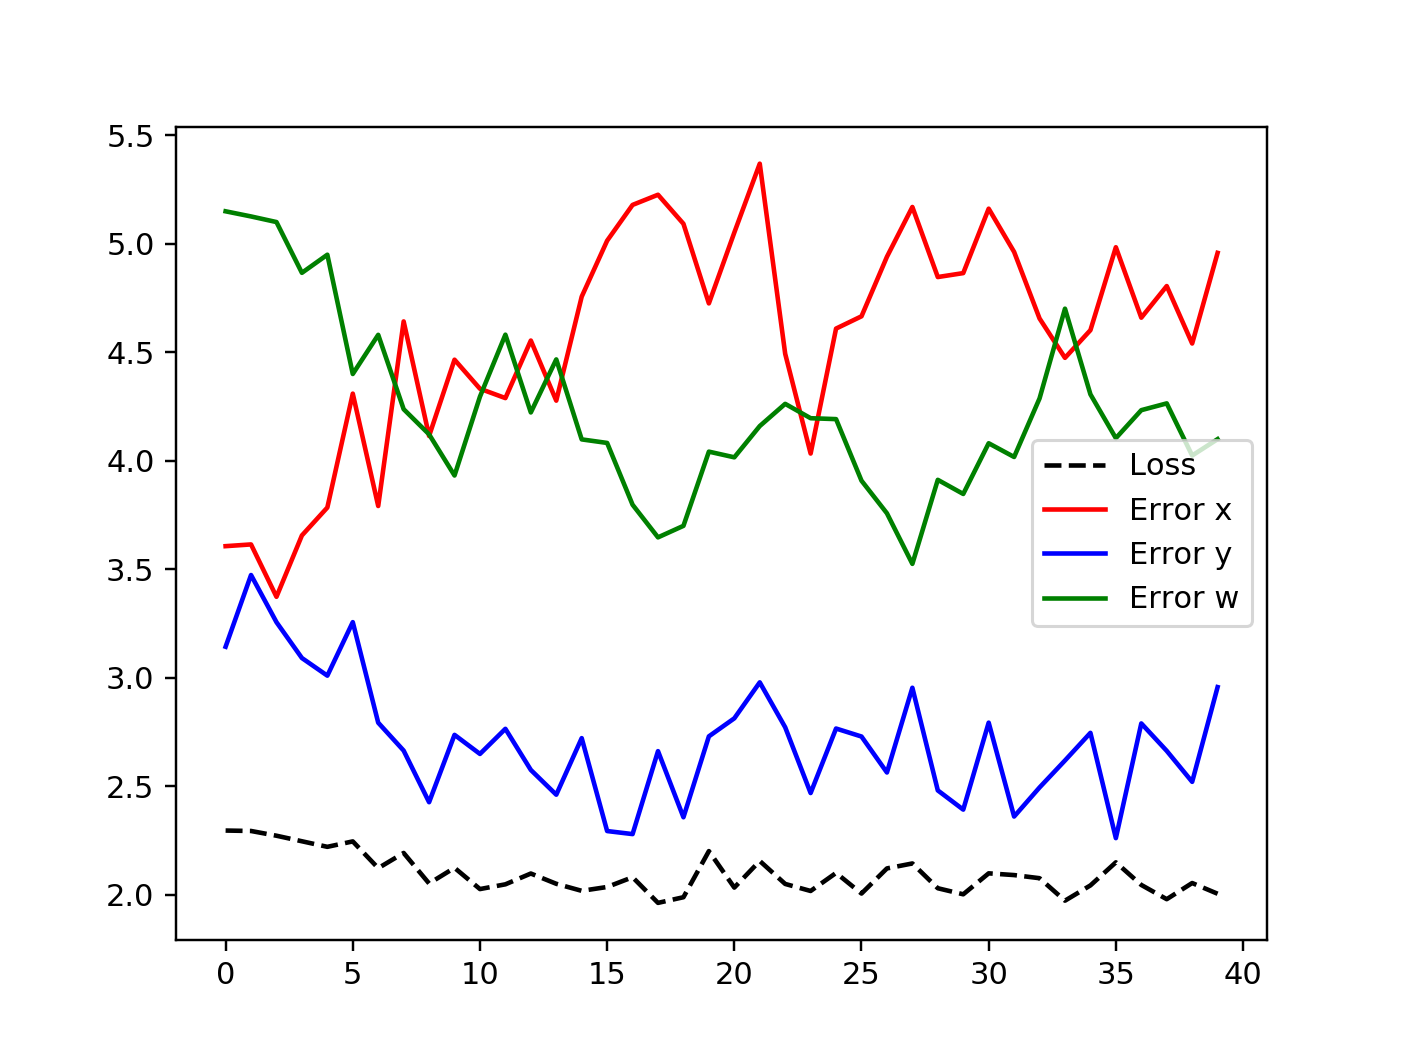

In [54]:
fig = plt.figure()#figsize=(10,5))
plt.plot(Loss, 'k--', label='Loss')
plt.plot(Error_x, c='r', label='Error x')
plt.plot(Error_y, c='b', label='Error y')
plt.plot(Error_w, c='g', label='Error w')
plt.legend()
plt.show()

In [39]:
np.argmax(pred, axis=1)

array([3, 3, 3, 4, 3, 3, 4, 3, 4, 2, 3, 2, 4, 3, 3, 3, 2, 3, 4, 4, 2, 2, 3,
       2, 4, 3, 4, 2, 2, 2, 4, 2, 3, 2, 4, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 4,
       3, 2, 2, 3, 2, 3, 4, 2, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 4, 4, 3,
       3, 2, 2, 3, 4, 3, 3, 4, 2, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3,
       3, 2, 3, 3, 2, 4, 3, 2, 4, 3, 2, 2, 3, 3, 4, 2, 3, 3, 4, 2, 3, 2, 4,
       2, 4, 3, 3, 2, 3, 2, 4, 2, 4, 2, 2, 2, 2, 2, 4, 3, 2, 4, 3, 4, 3, 2,
       2, 3, 4, 2, 3, 3, 3, 3, 2, 3, 3, 4, 3, 3, 4, 3, 3, 2, 2, 3, 4, 3, 3,
       3, 3, 2, 2, 3, 3, 3, 4, 2, 2, 3, 4, 2, 4, 2, 2, 3, 3, 2, 2, 2, 3, 3,
       4, 2, 4, 3, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3,
       4, 2, 3, 2, 4, 4, 3, 2, 3, 4, 3, 2, 2, 4, 2, 2, 3, 3, 3, 4, 4, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 2, 2, 2, 2, 3, 4, 2, 3, 3, 3, 3, 2, 2,
       4, 2, 3, 3, 3, 2, 2, 3, 4, 3, 3, 2, 3, 3, 4, 3, 2, 4, 3, 3, 4, 4, 3,
       2, 2, 4, 3, 2, 3, 3, 3, 2, 4, 2, 3, 4, 4, 3, 3])

In [ ]:
# fig = plt.figure(figsize=(10,5))
# plt.plot(np.multiply(Error_x, 1920.0), c='r', label='Error x [pixels]')
# plt.plot(np.multiply(Error_y, 1080.0), c='b', label='Error y [pixels]')
# # plt.plot(Error_w*2*3.1415, c='g', label='Error w [radians]')
# plt.legend()
# plt.show()

In [28]:
# Create image tranforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.CenterCrop((172,172)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

# Create datasets
root = '/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/'
dataset = pytorch_datasets.NeedleMaster(root, train_split=None, transforms=transforms, discrete=MODE=='classify')
# Create dataloaders
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True,  batch_size=256,  num_workers=multiprocessing.cpu_count())

<IPython.core.display.Javascript object>


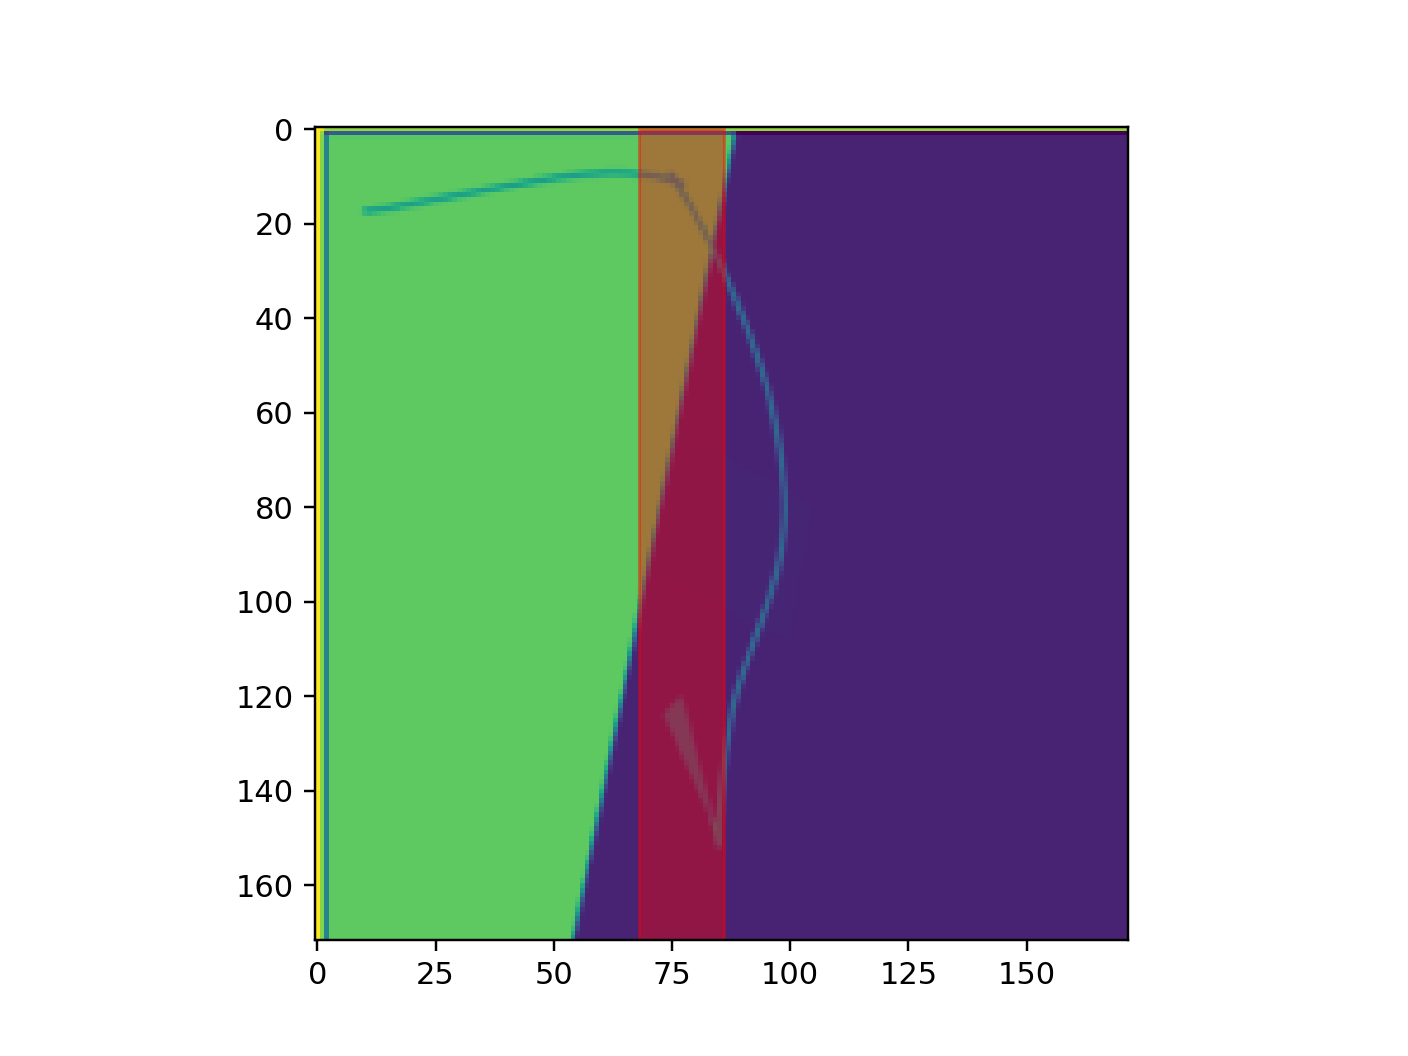

needle pose: tensor([4, 8, 6])


<IPython.core.display.Javascript object>


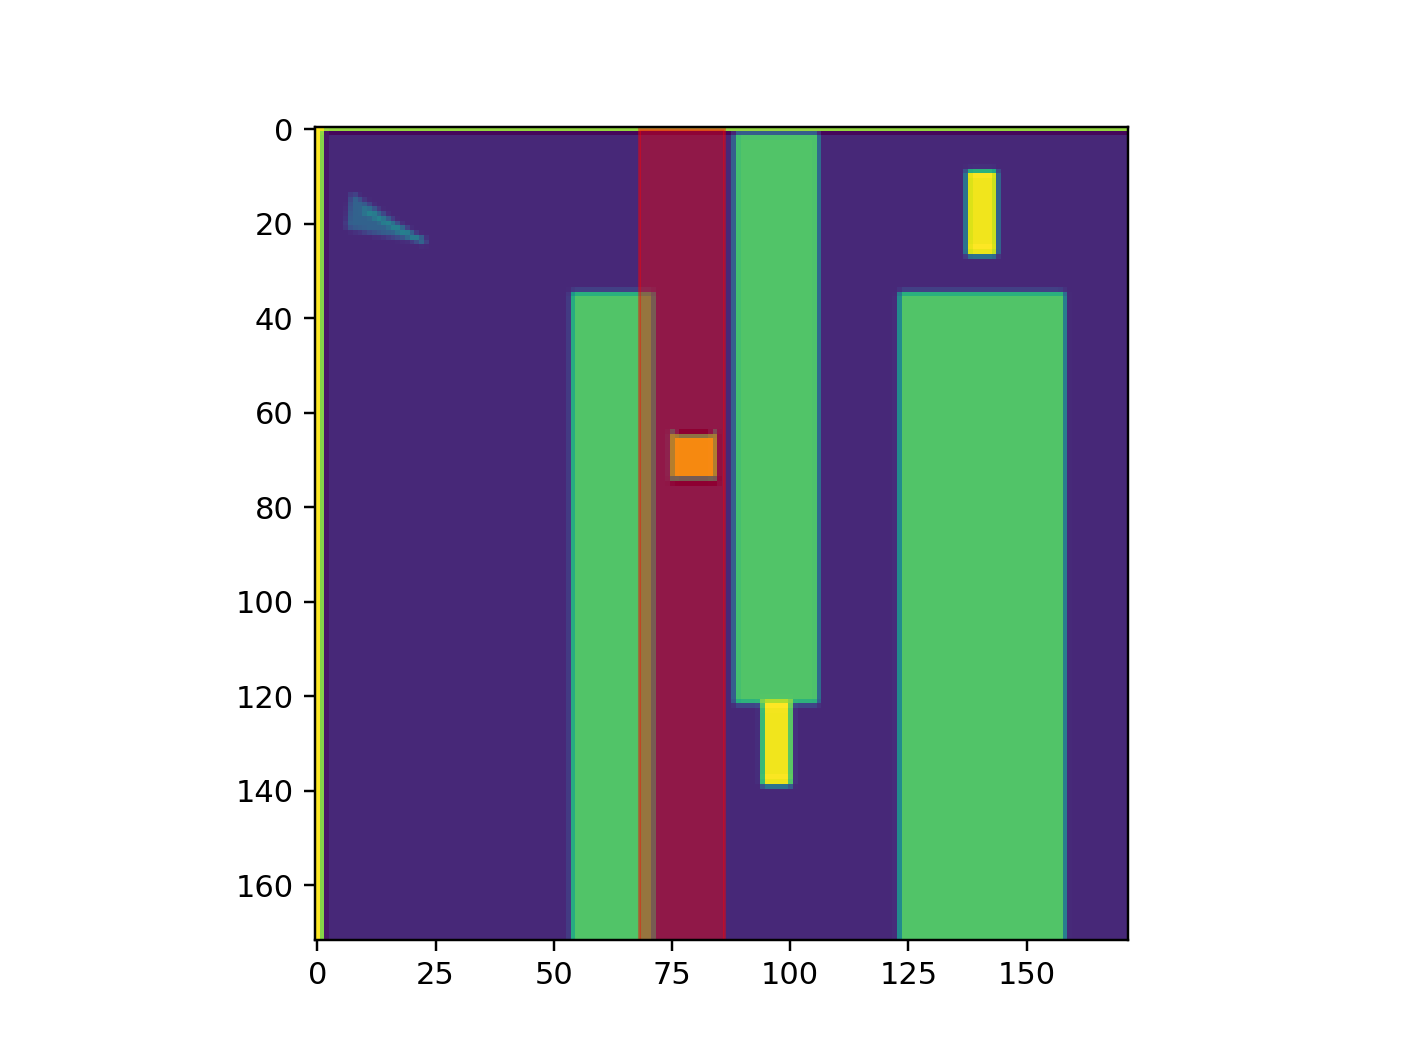

needle pose: tensor([1, 1, 5])


<IPython.core.display.Javascript object>


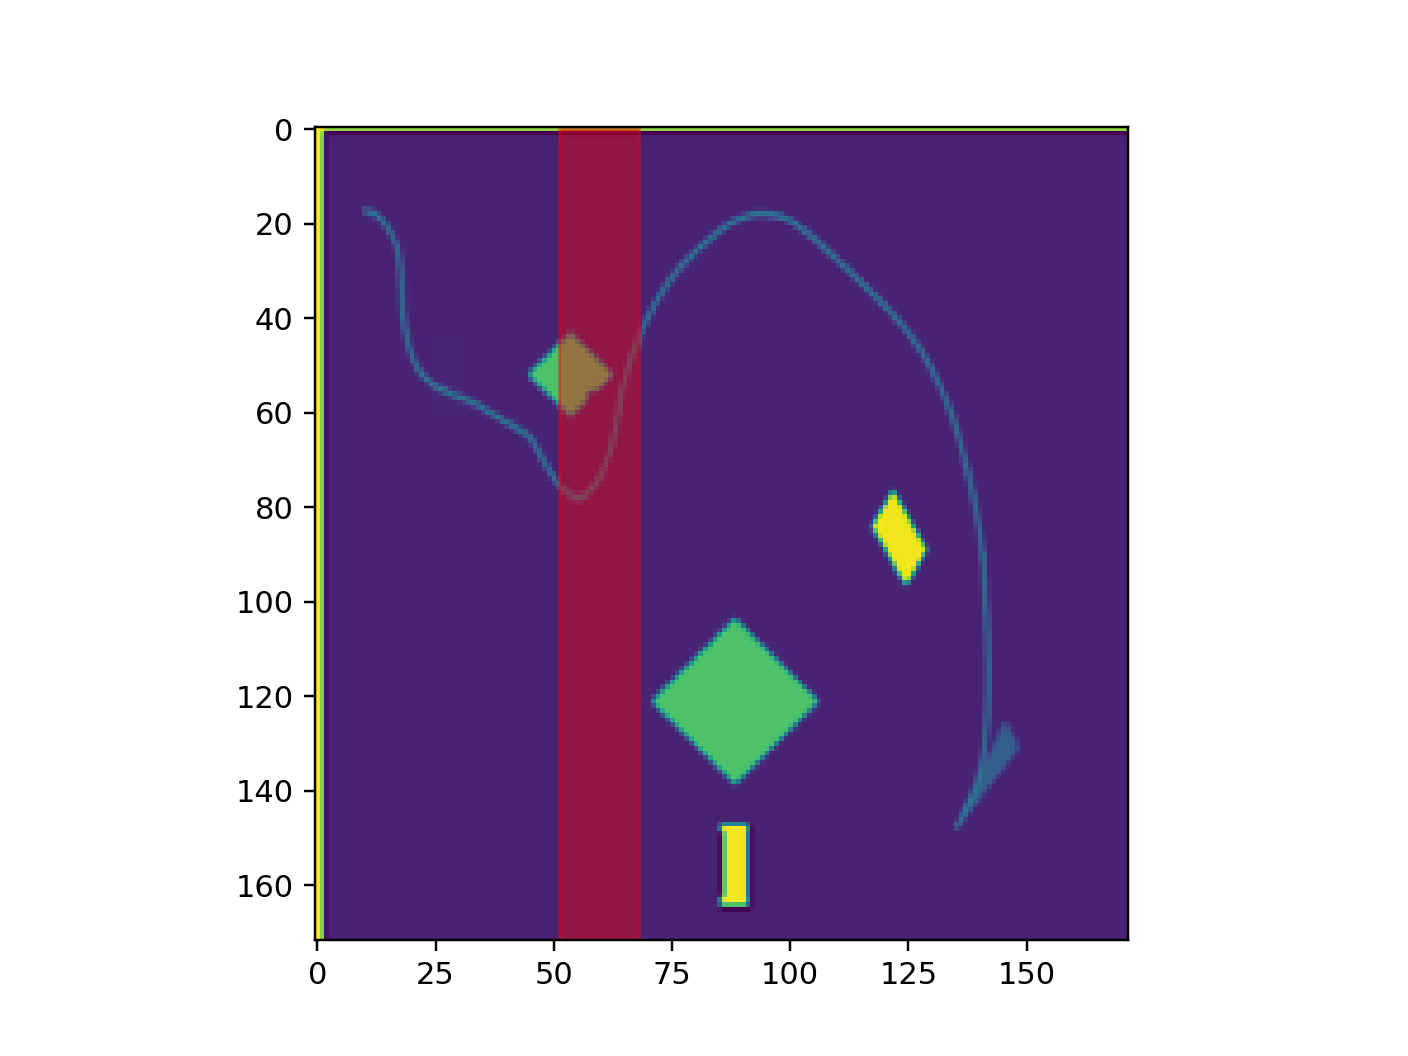

needle pose: tensor([7, 8, 8])


<IPython.core.display.Javascript object>


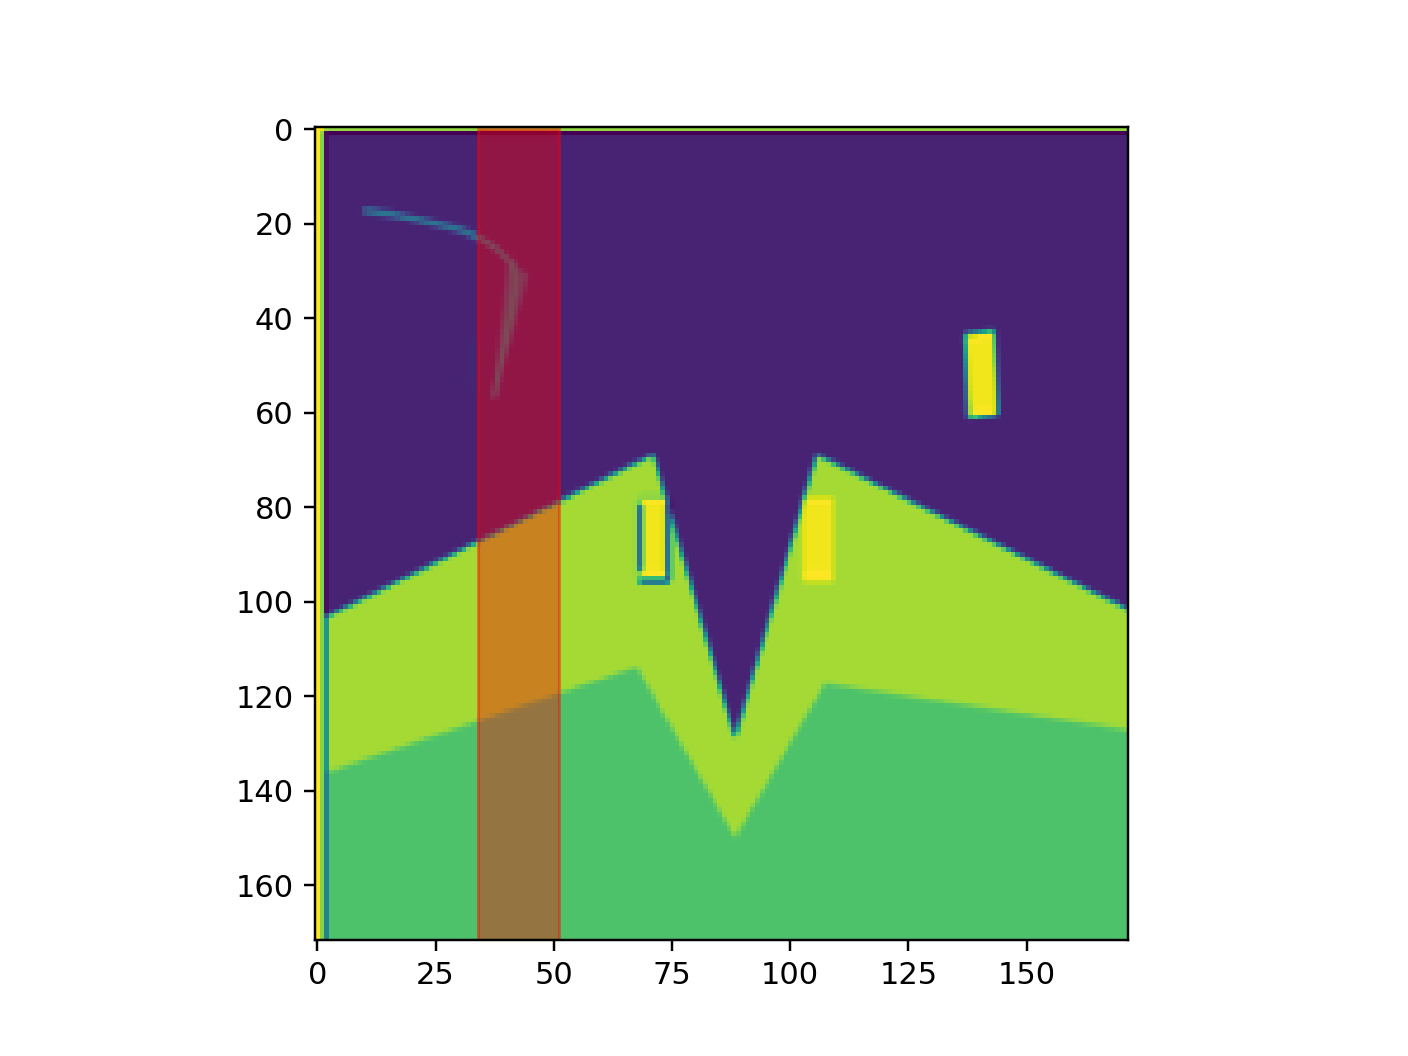

needle pose: tensor([2, 3, 7])


<IPython.core.display.Javascript object>


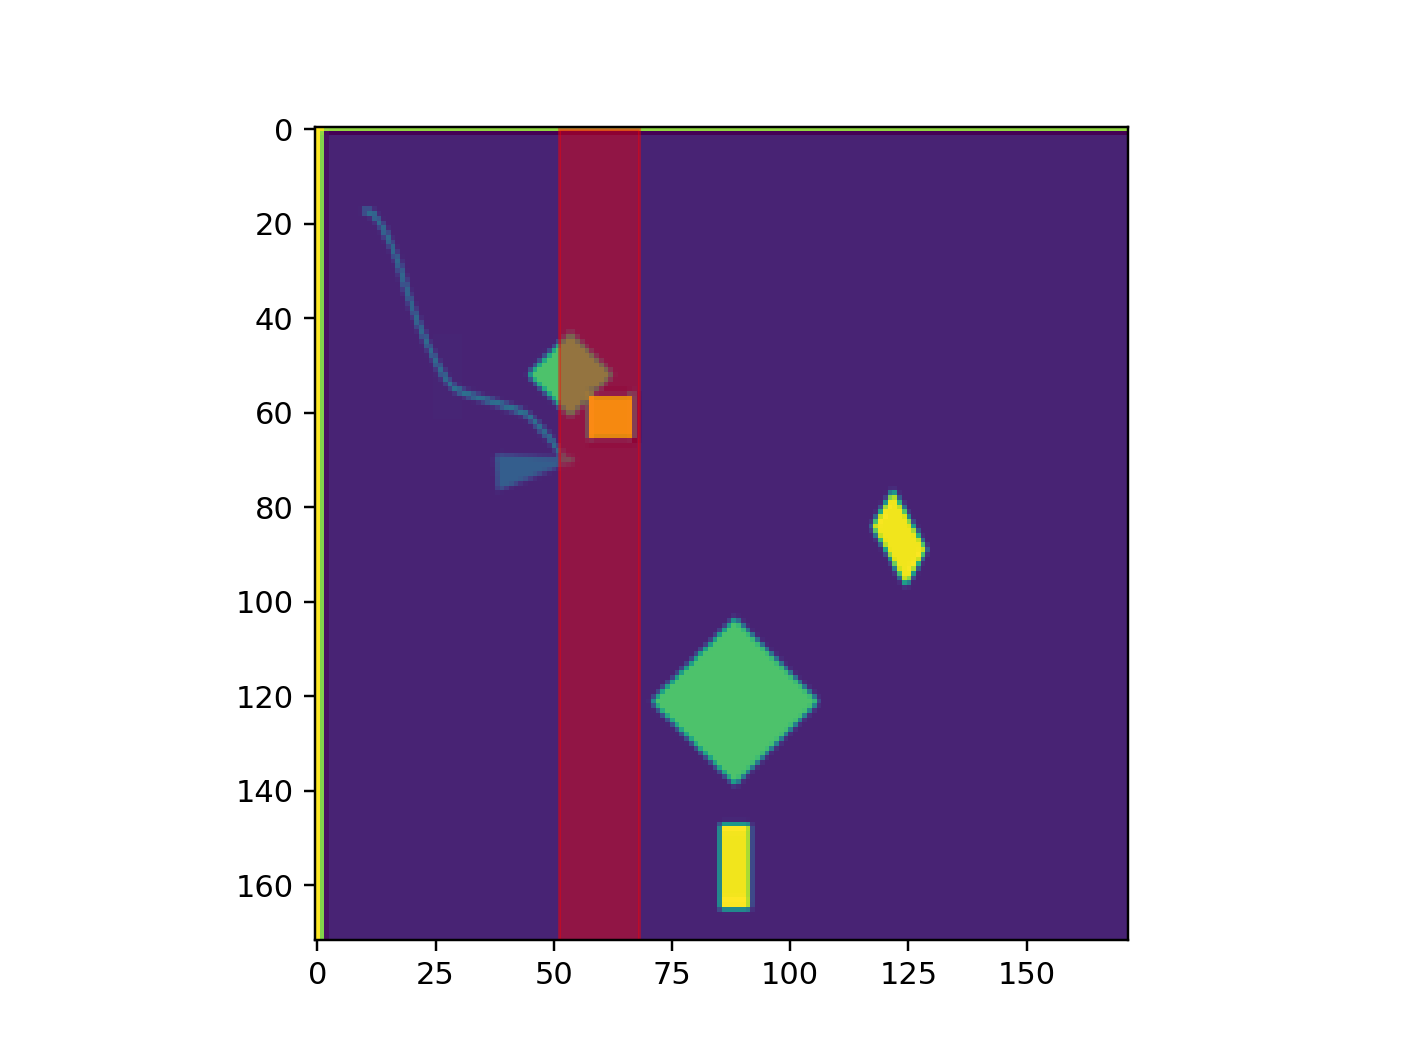

needle pose: tensor([3, 4, 4])


<IPython.core.display.Javascript object>


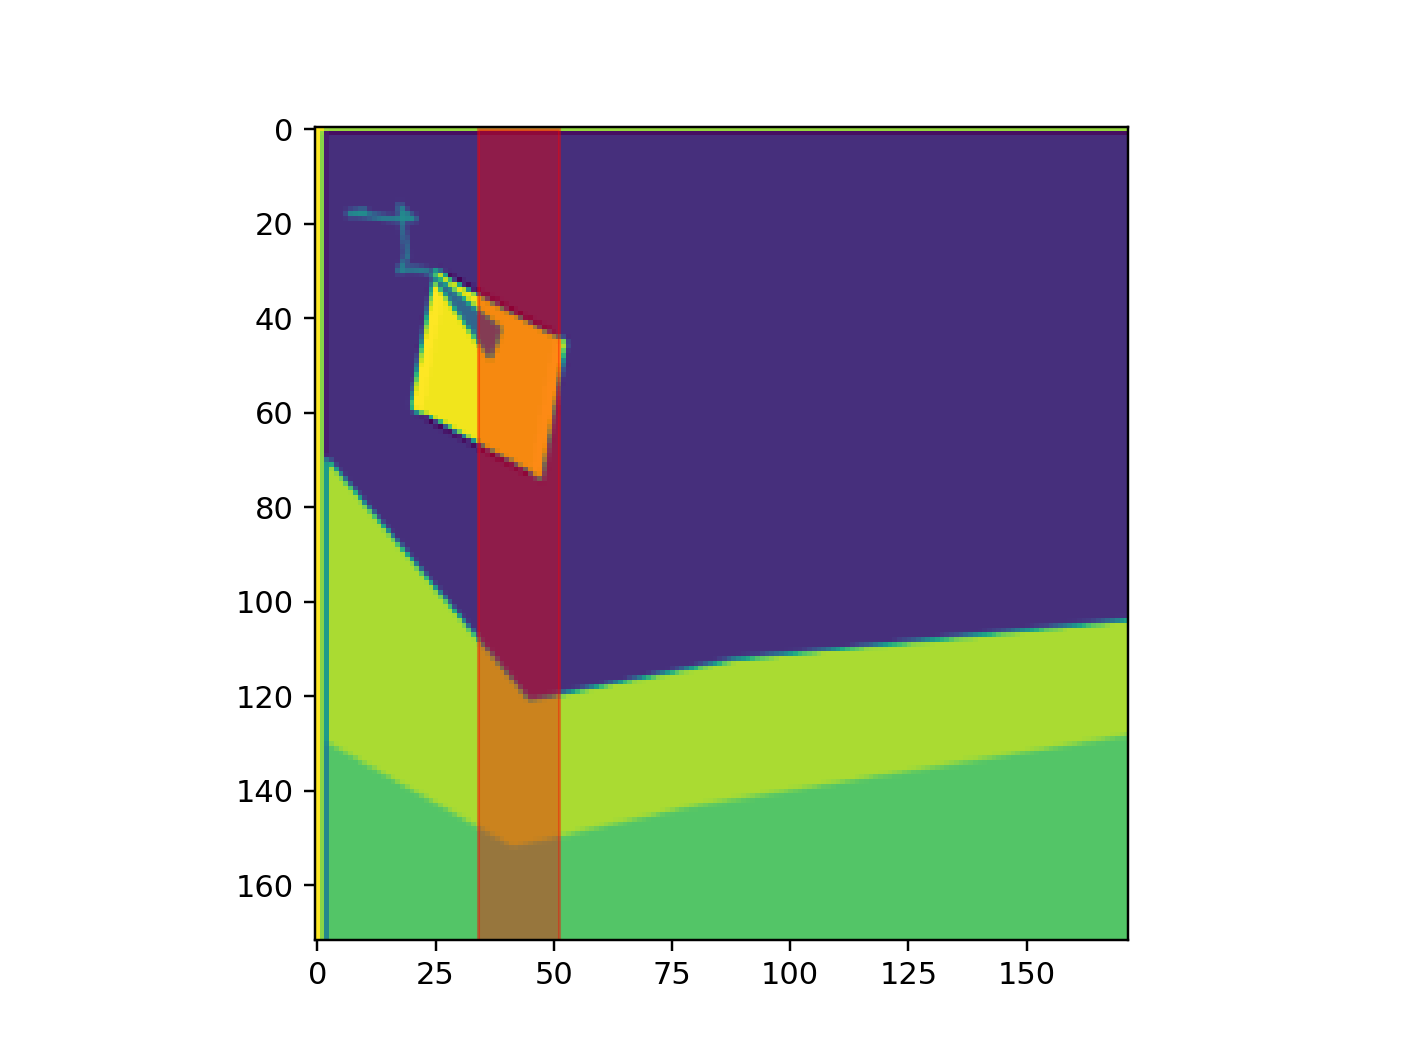

needle pose: tensor([1, 2, 1])


<IPython.core.display.Javascript object>


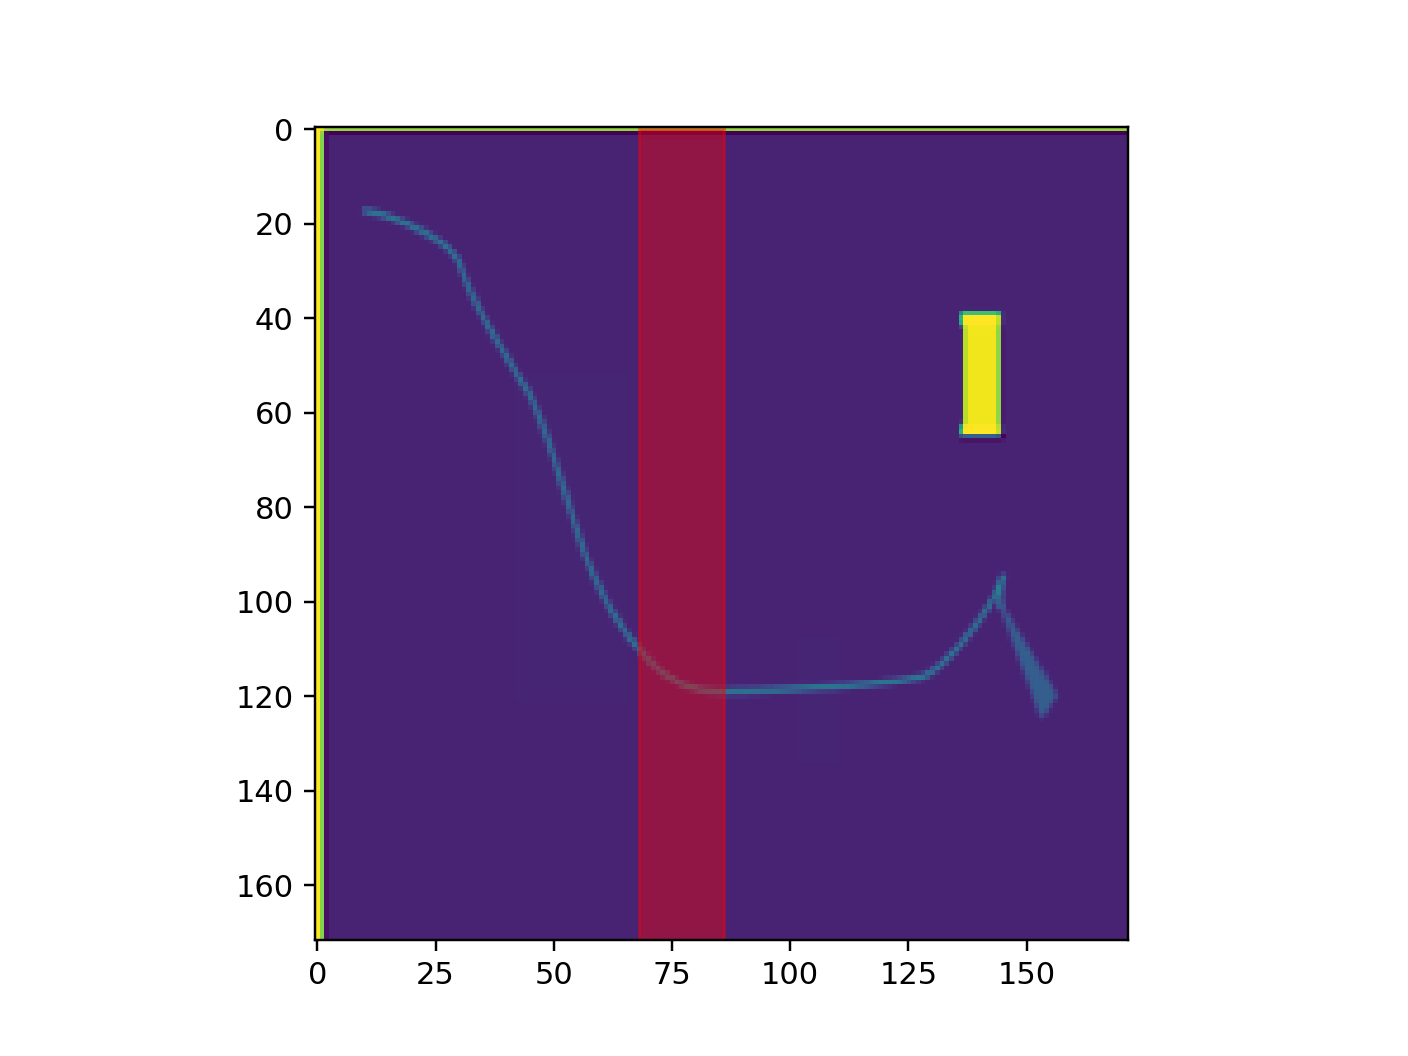

needle pose: tensor([7, 5, 1])


<IPython.core.display.Javascript object>


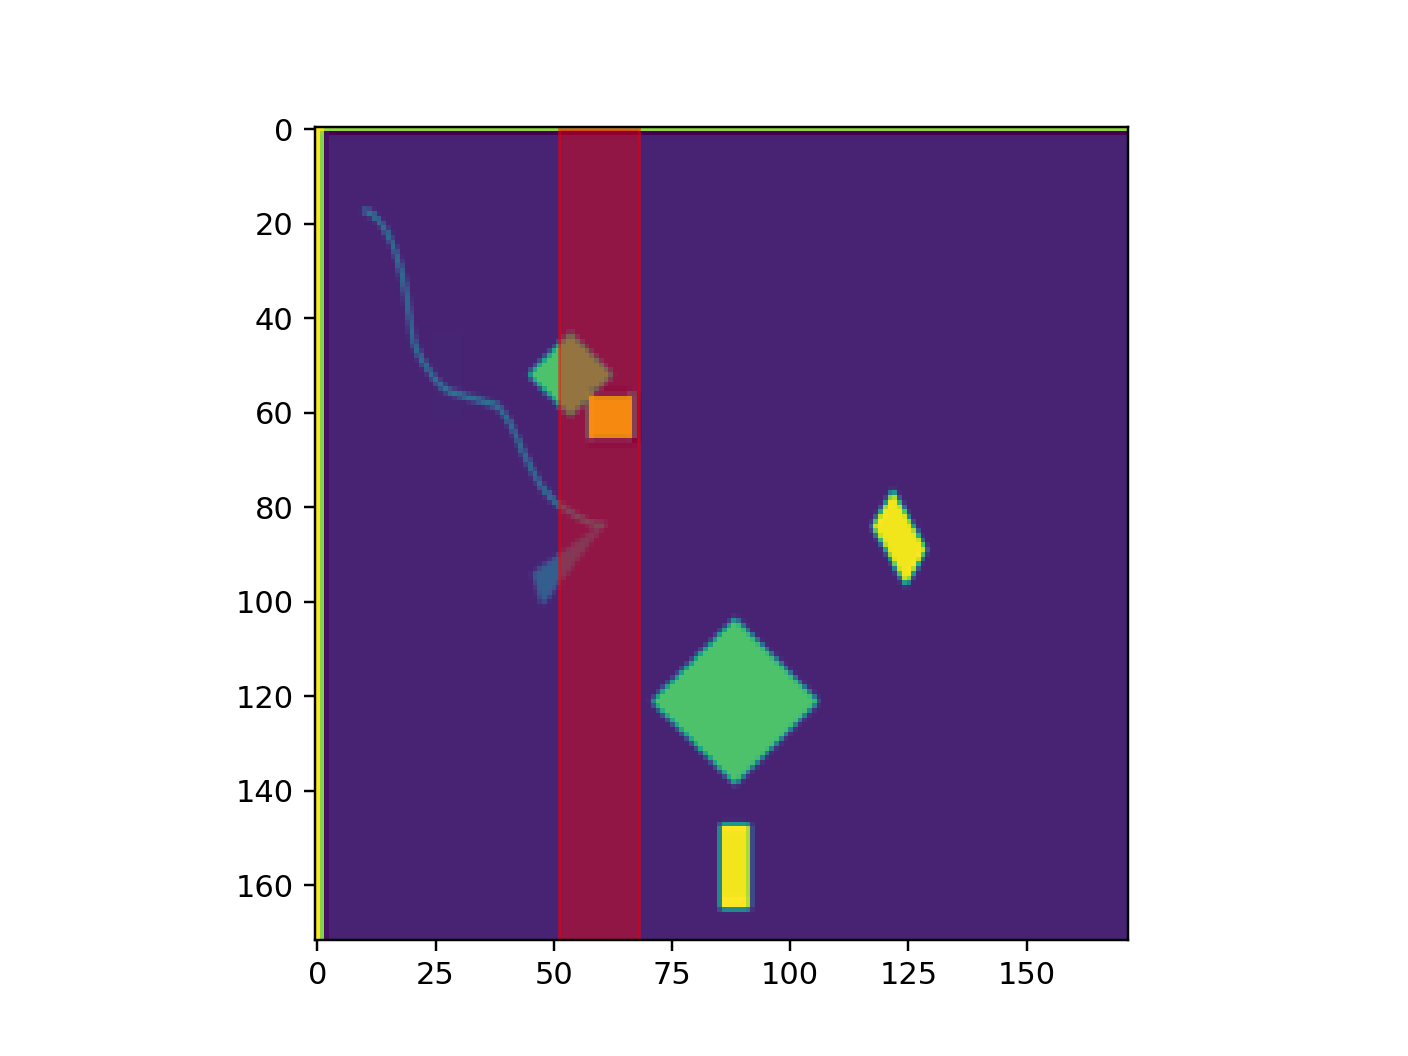

needle pose: tensor([3, 4, 4])


<IPython.core.display.Javascript object>


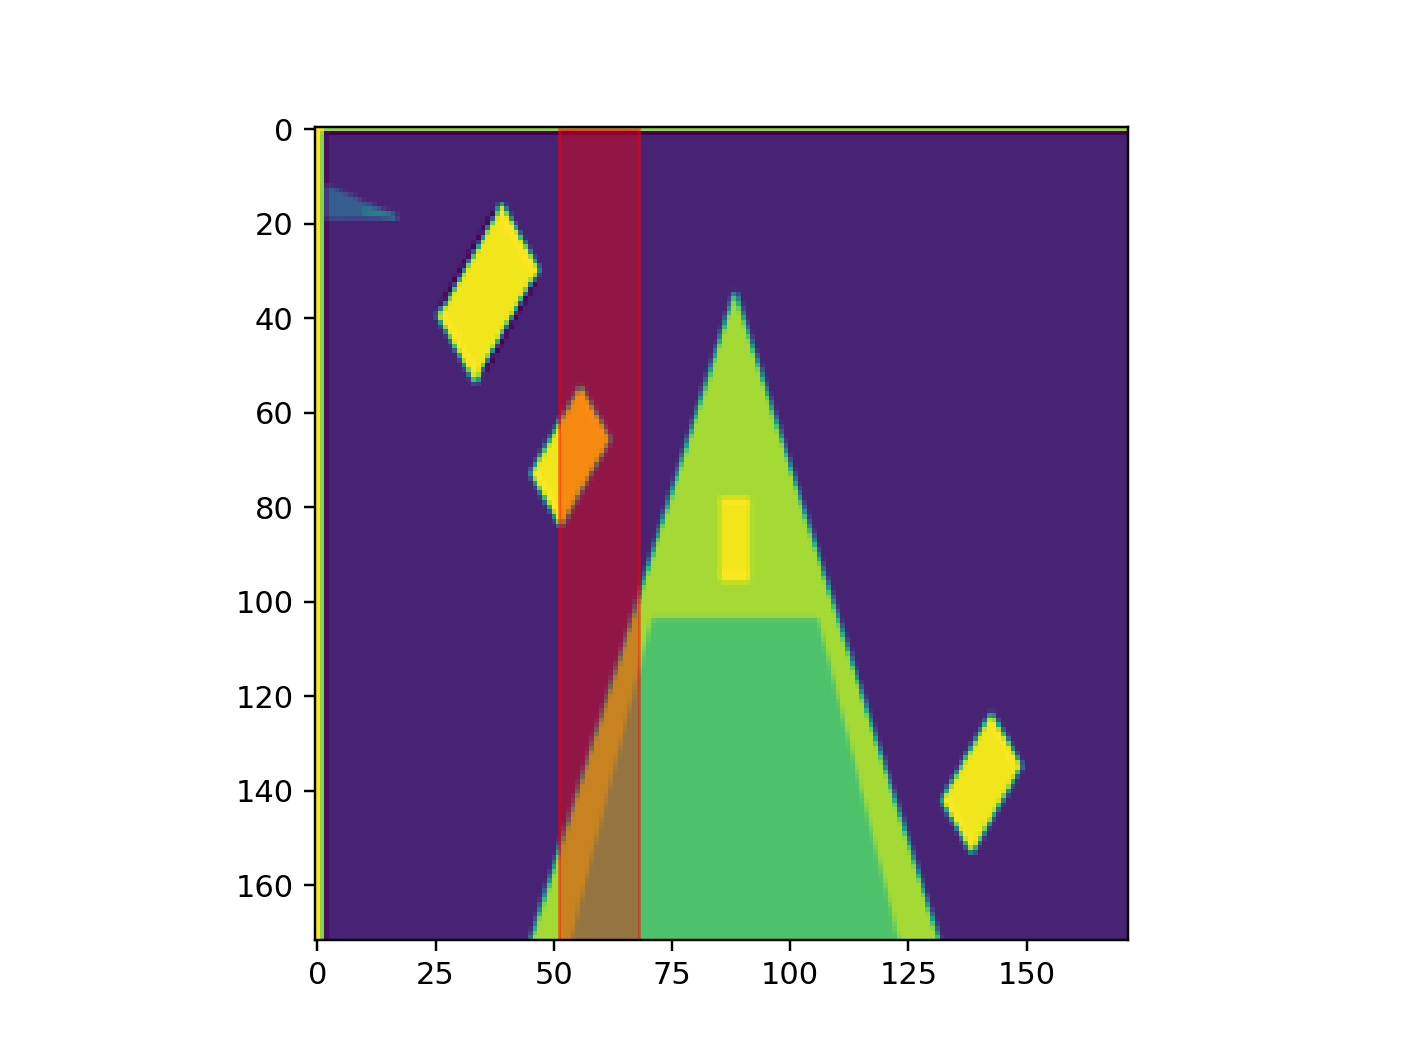

needle pose: tensor([1, 1, 5])


<IPython.core.display.Javascript object>


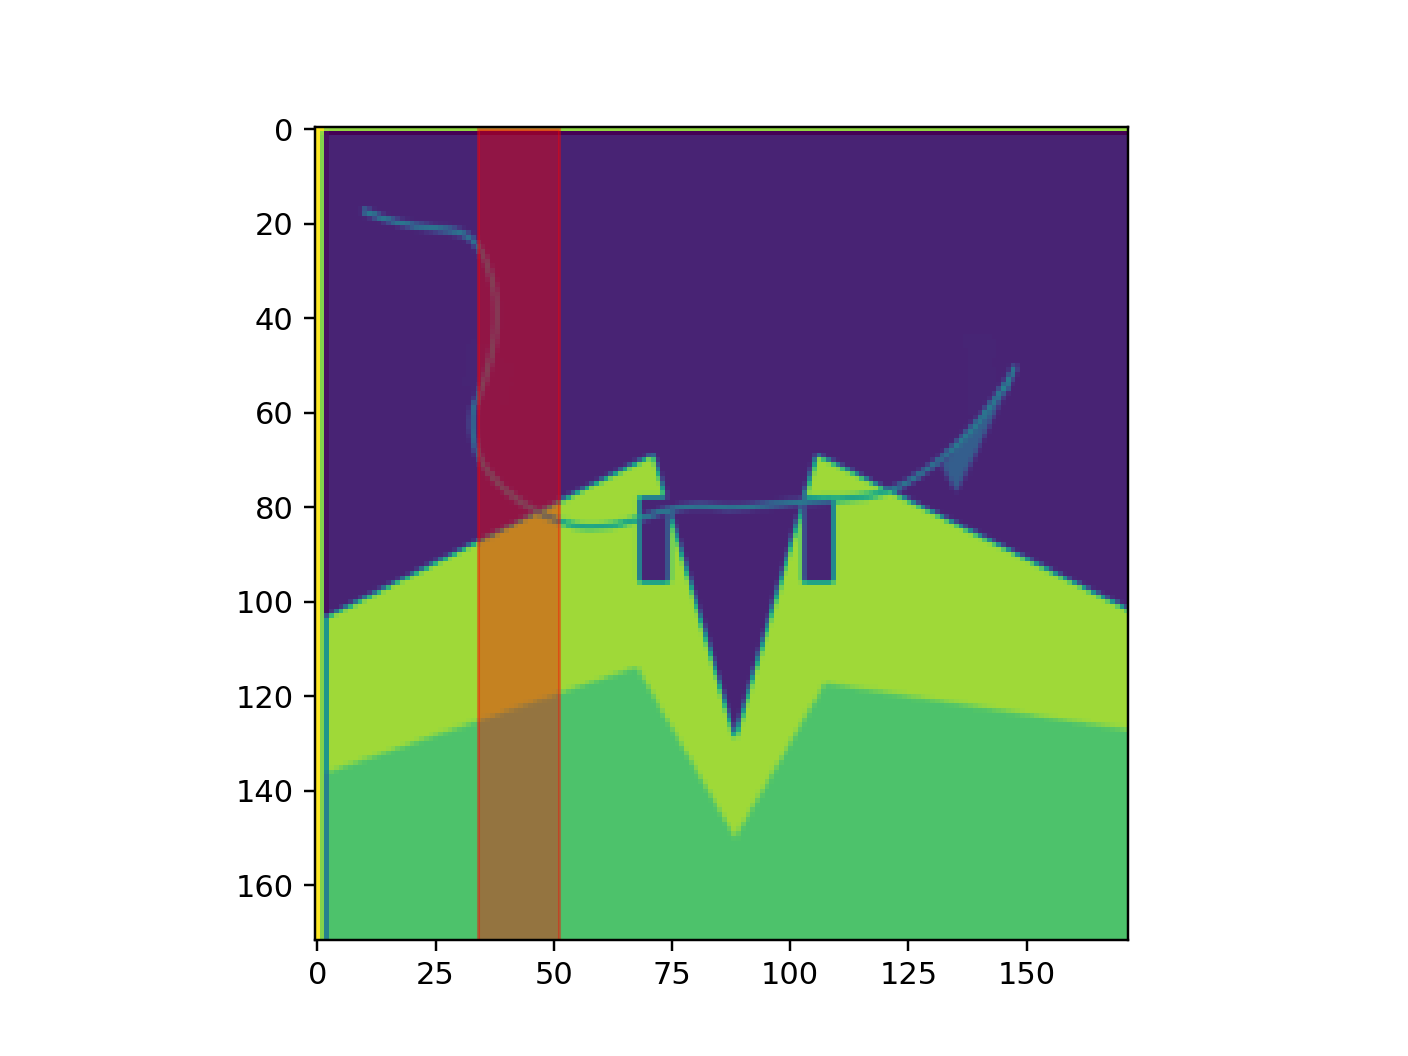

needle pose: tensor([7, 3, 3])


<IPython.core.display.Javascript object>


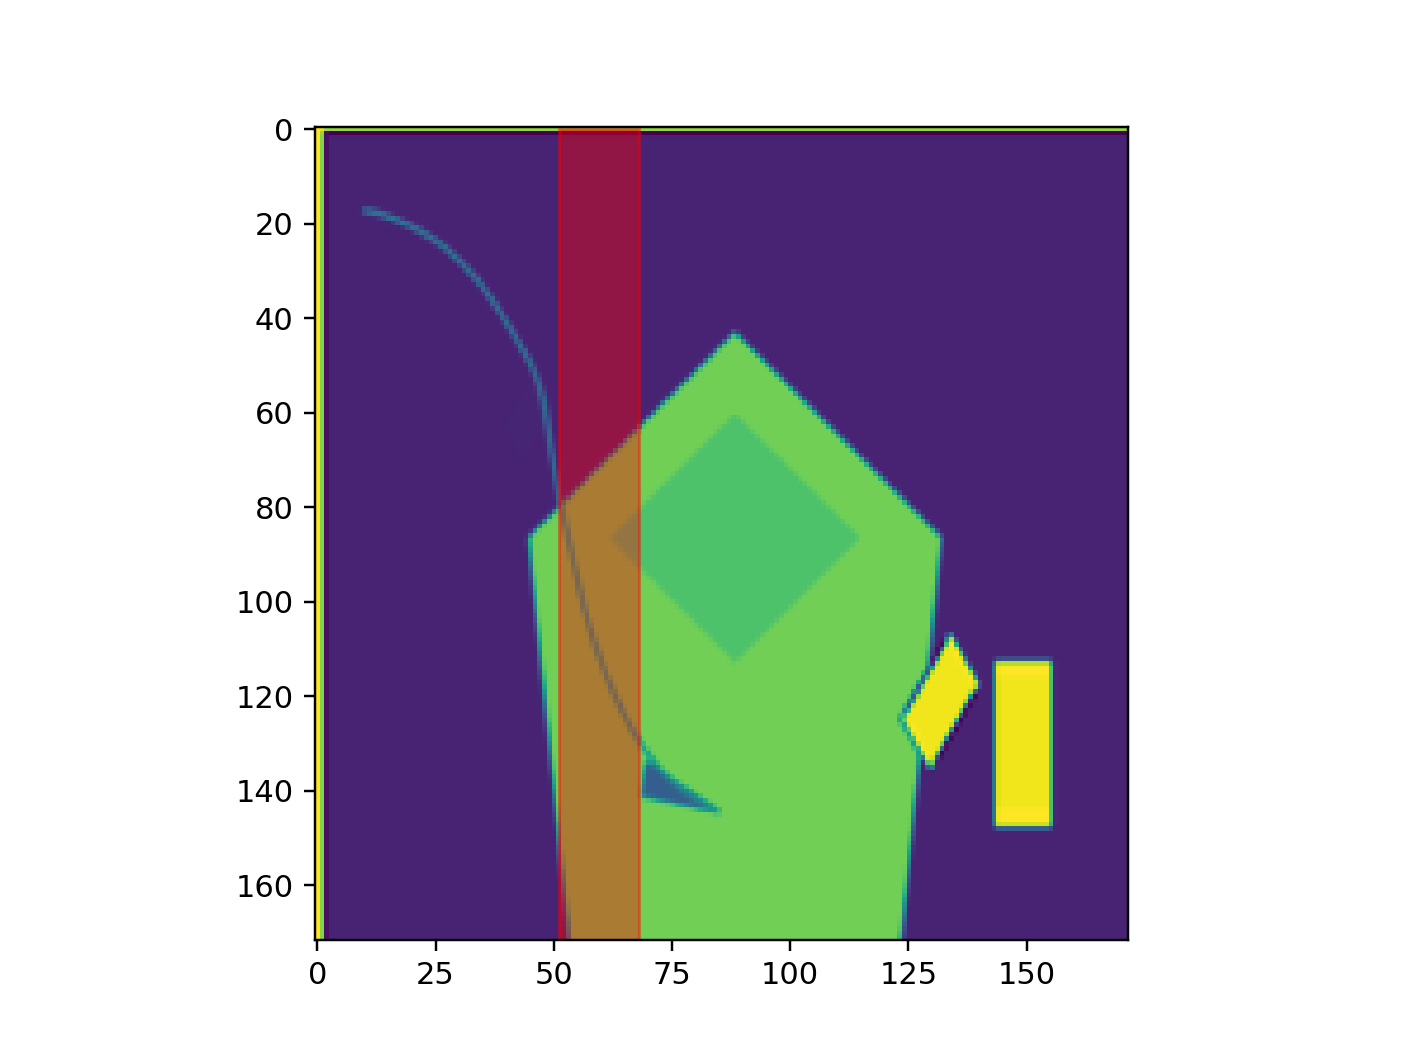

needle pose: tensor([4, 8, 5])


<IPython.core.display.Javascript object>


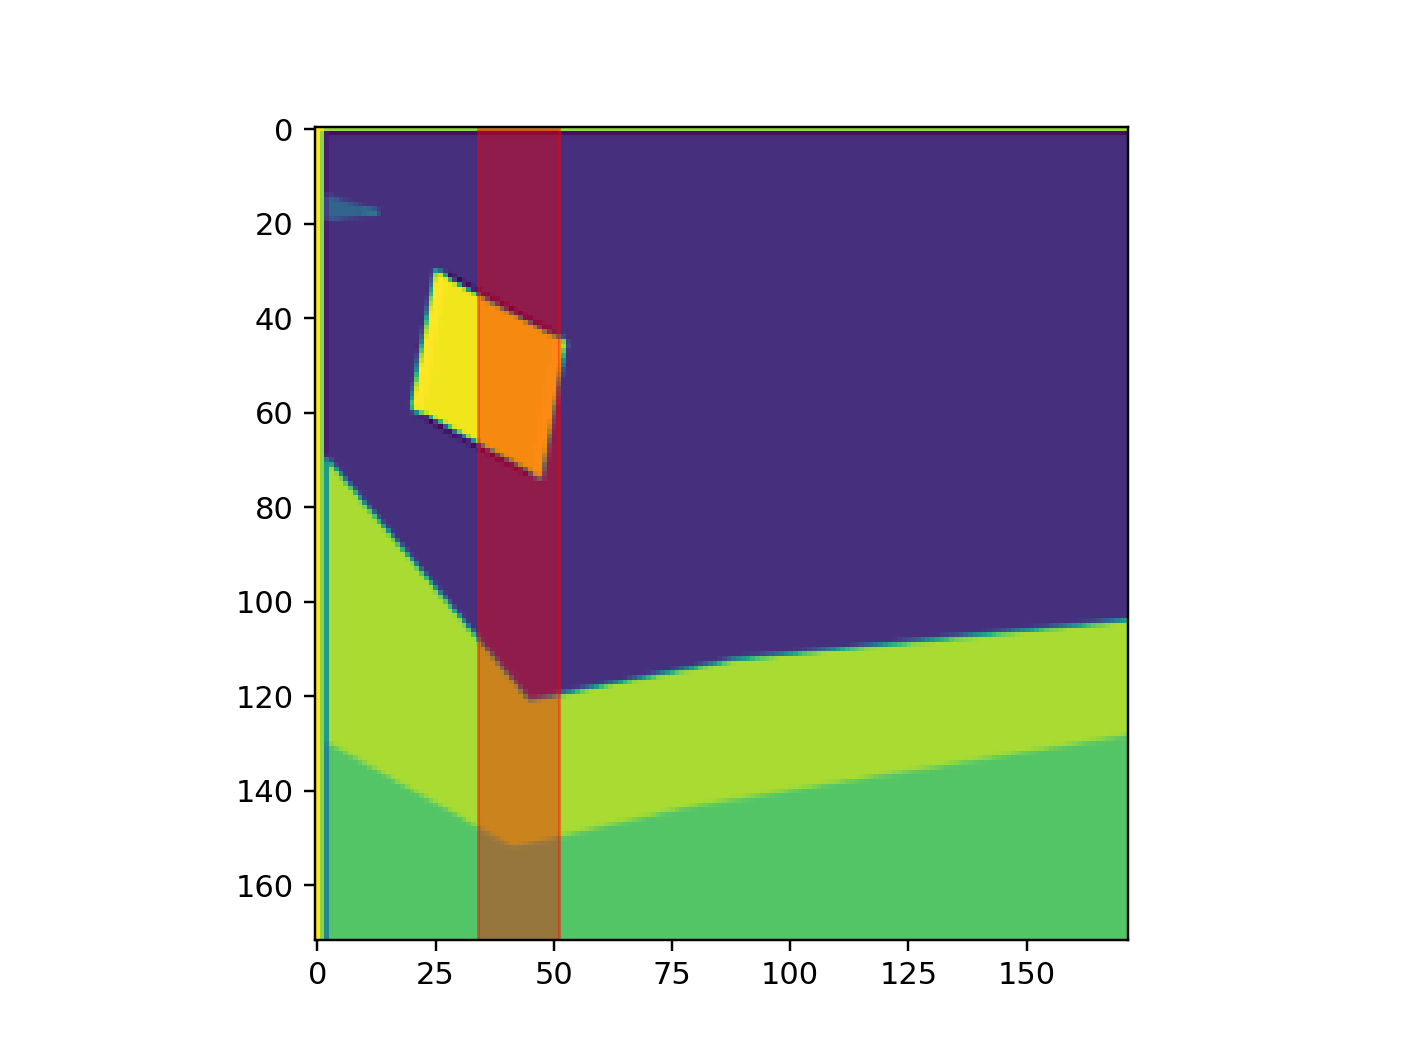

needle pose: tensor([1, 1, 5])


<IPython.core.display.Javascript object>


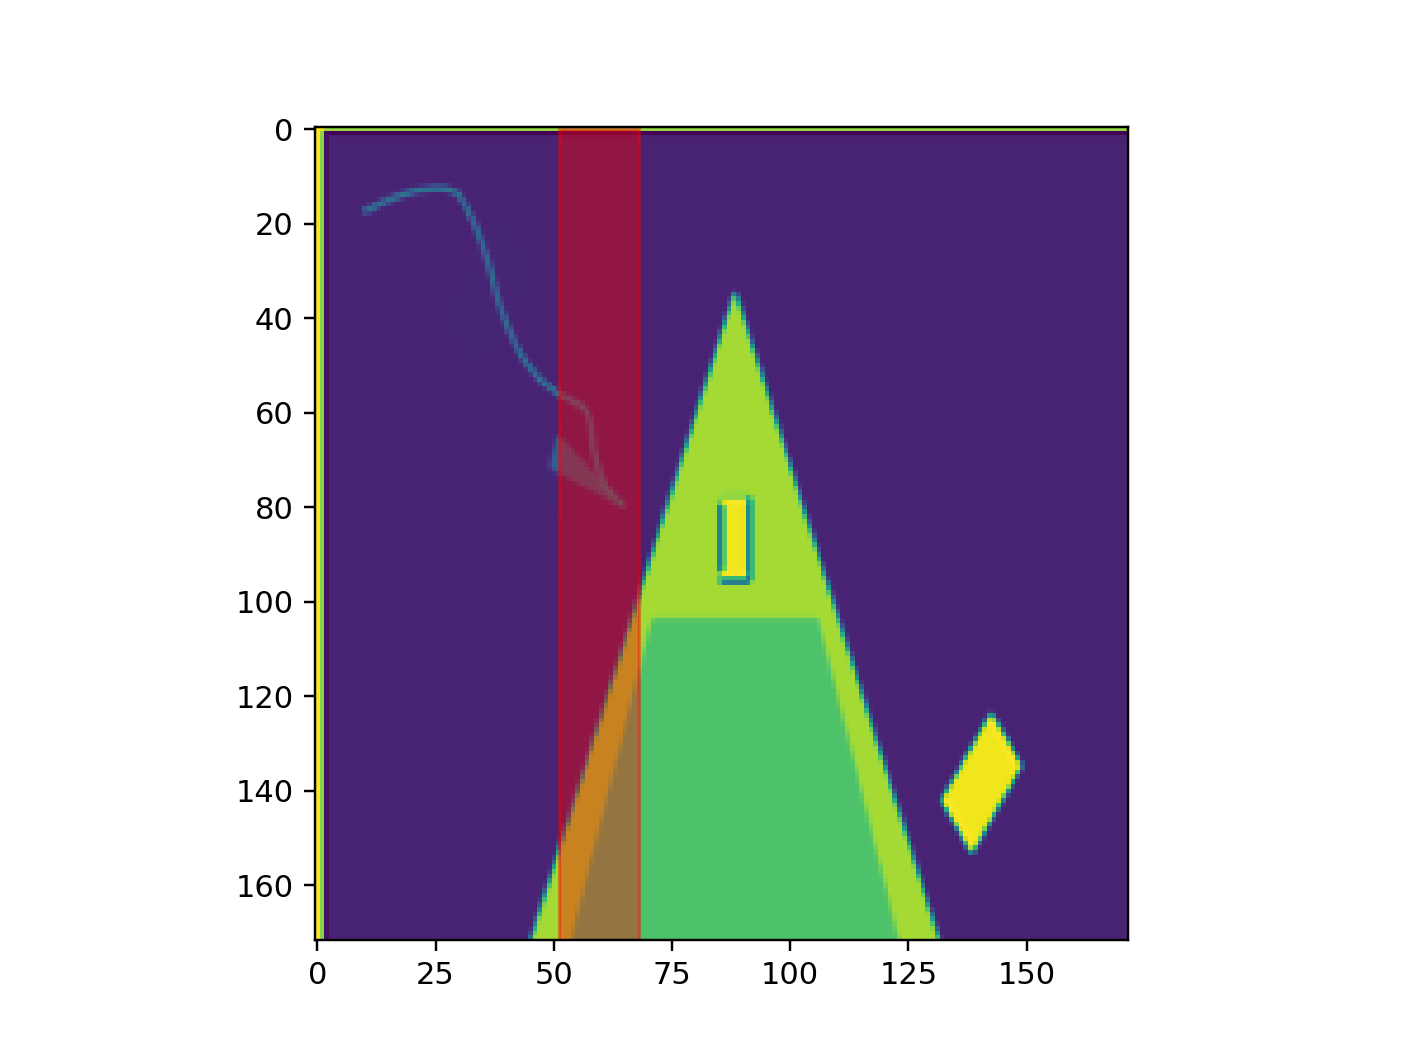

needle pose: tensor([3, 4, 5])


<IPython.core.display.Javascript object>


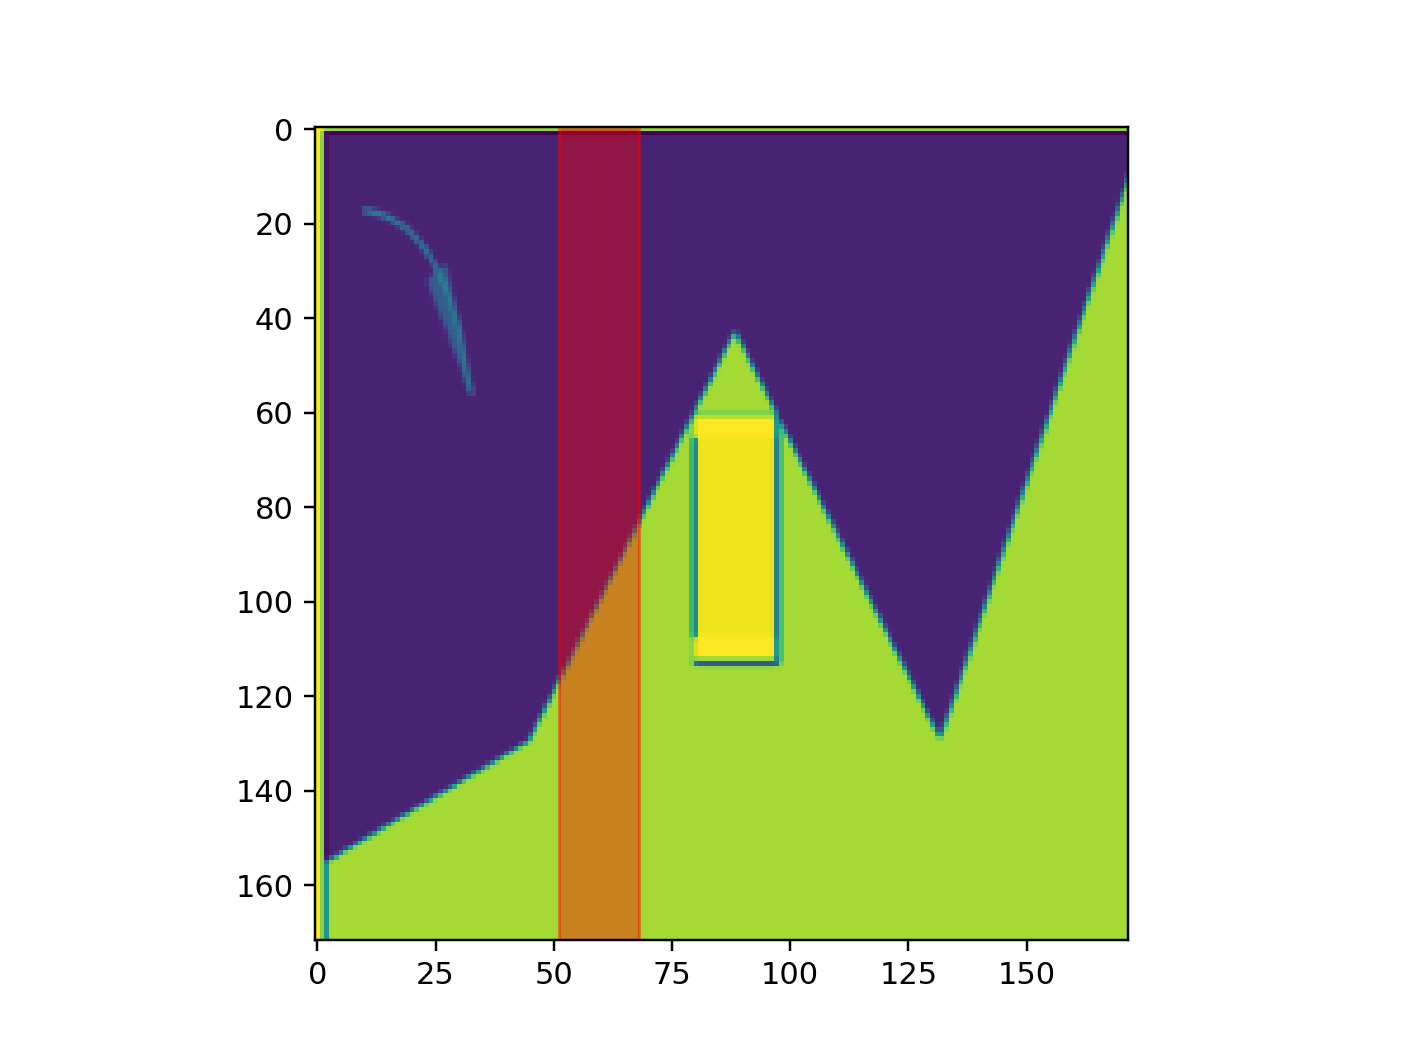

needle pose: tensor([2, 3, 6])


<IPython.core.display.Javascript object>


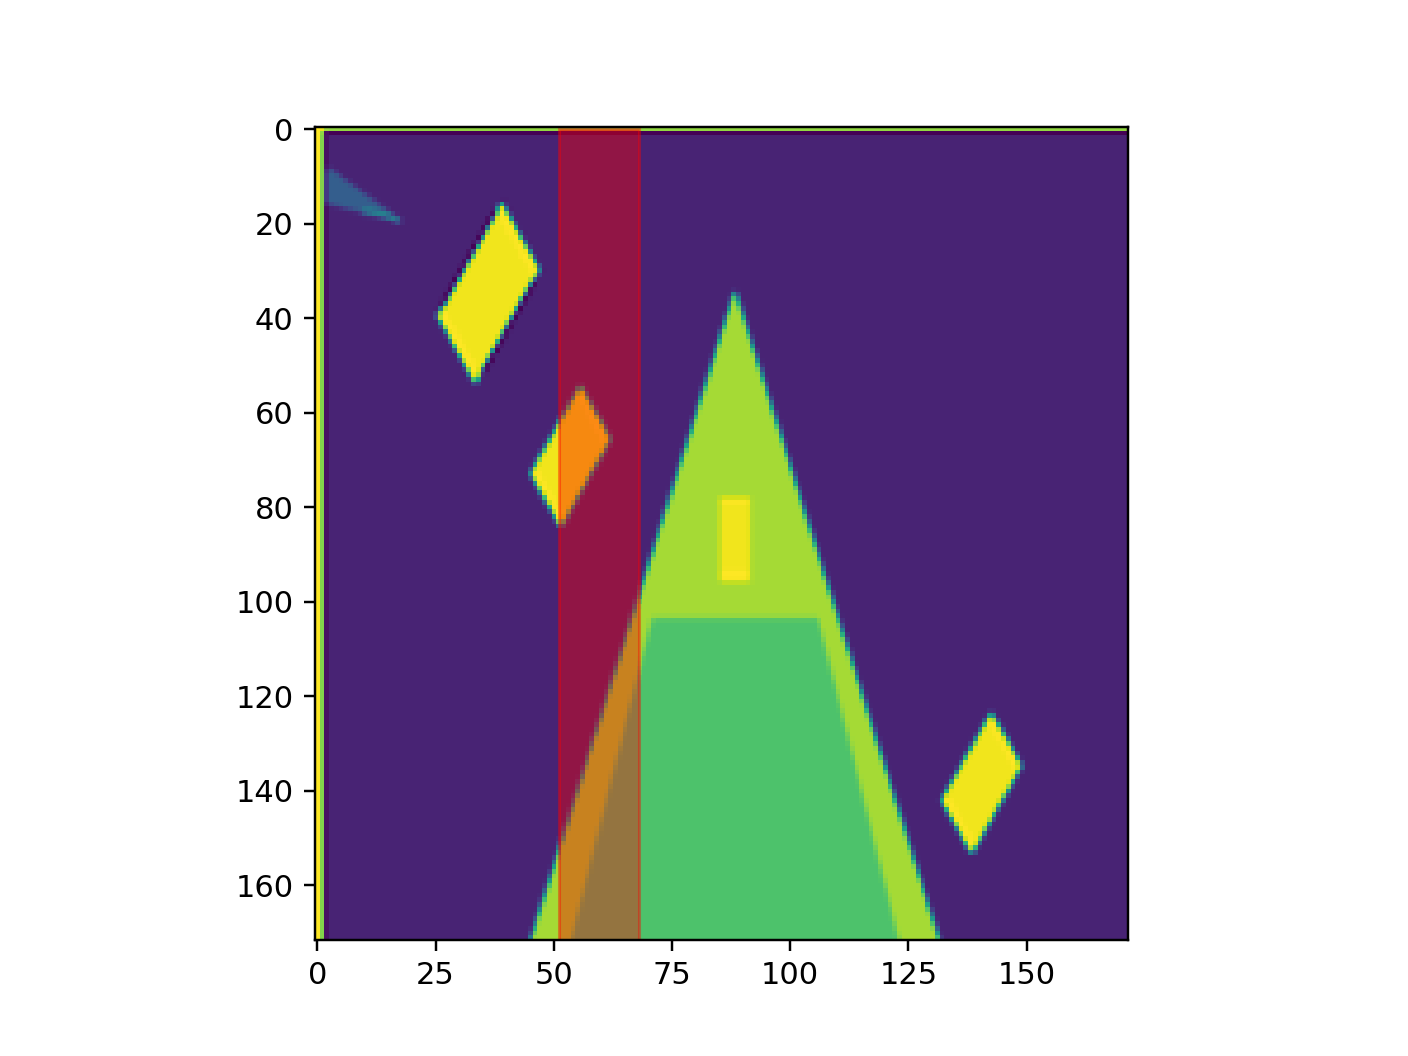

needle pose: tensor([1, 1, 5])


<IPython.core.display.Javascript object>


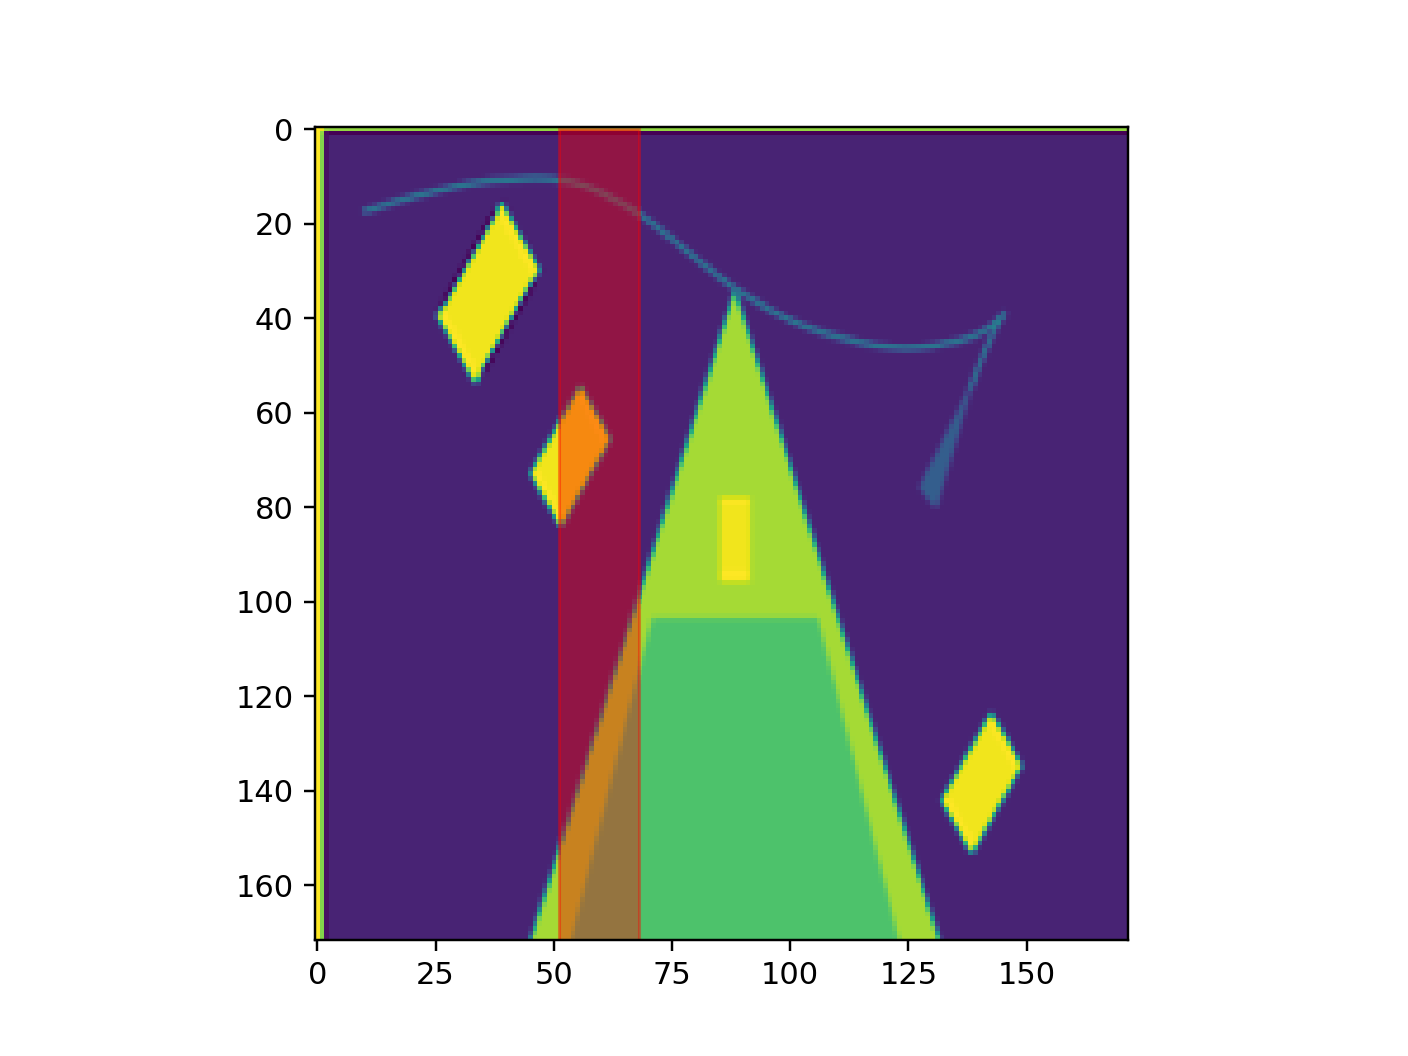

needle pose: tensor([7, 3, 3])


<IPython.core.display.Javascript object>


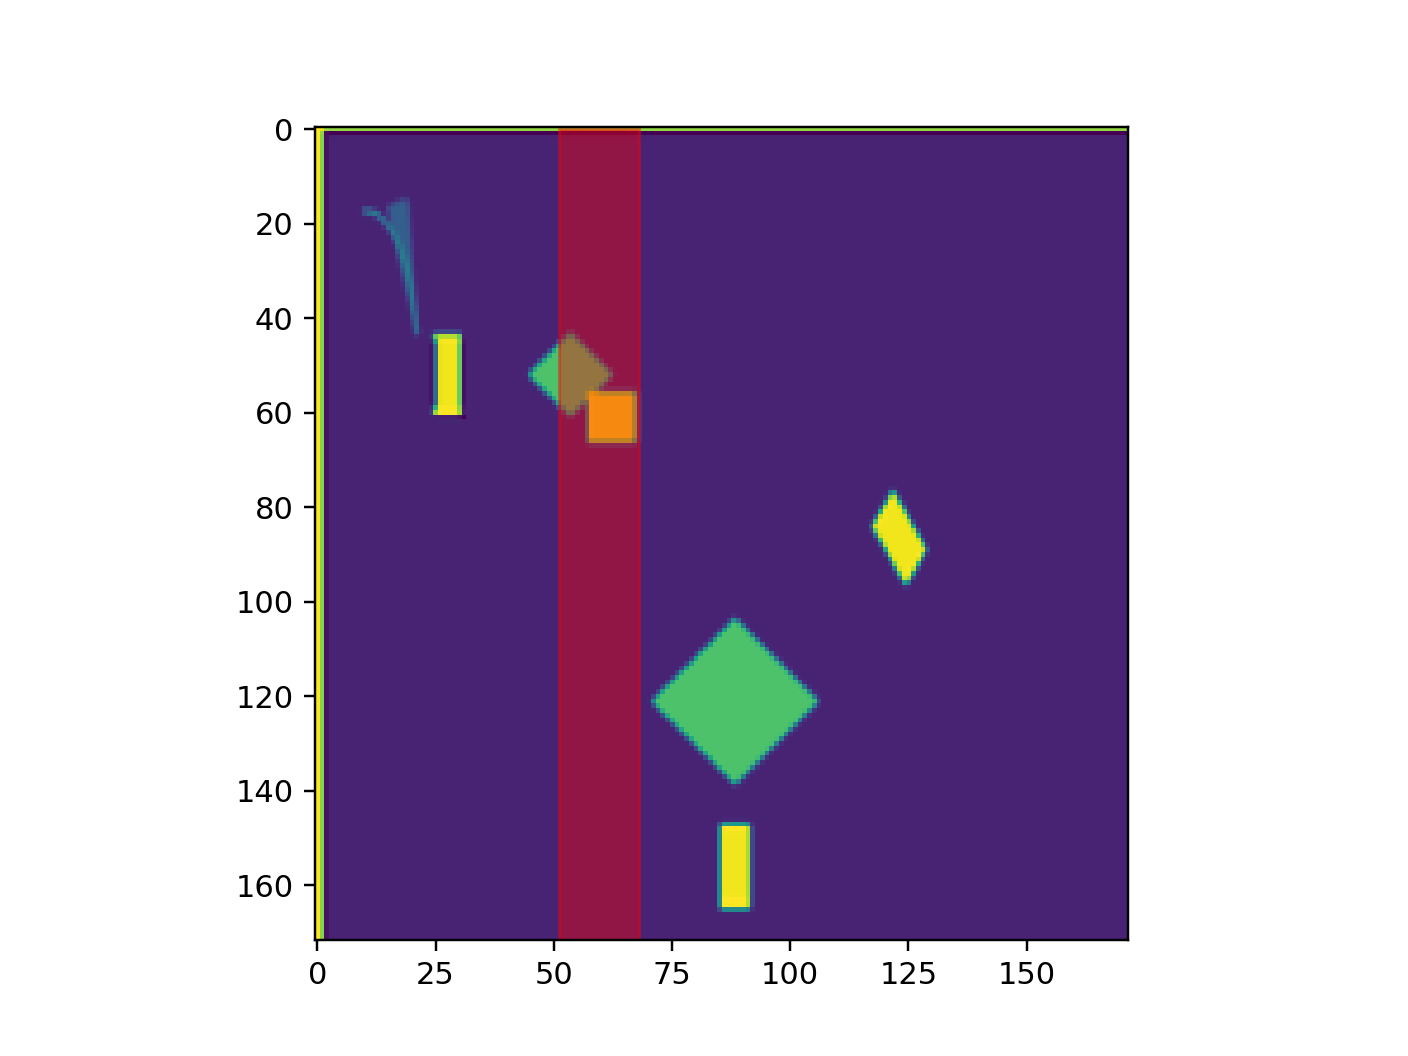

needle pose: tensor([1, 2, 6])


<IPython.core.display.Javascript object>


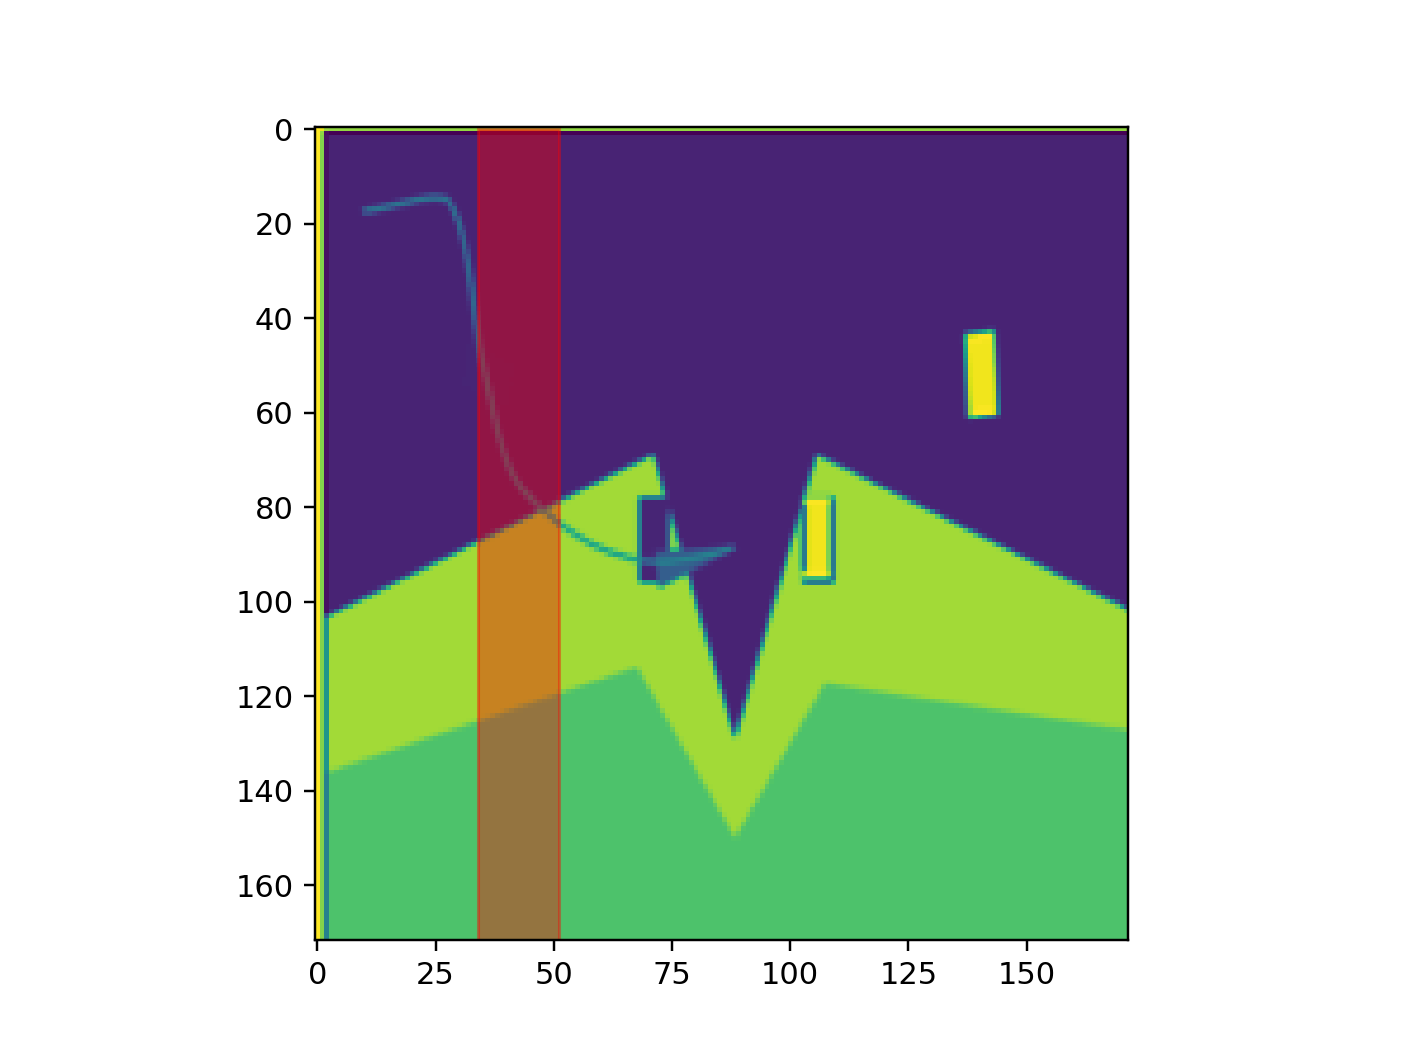

needle pose: tensor([4, 5, 4])


<IPython.core.display.Javascript object>


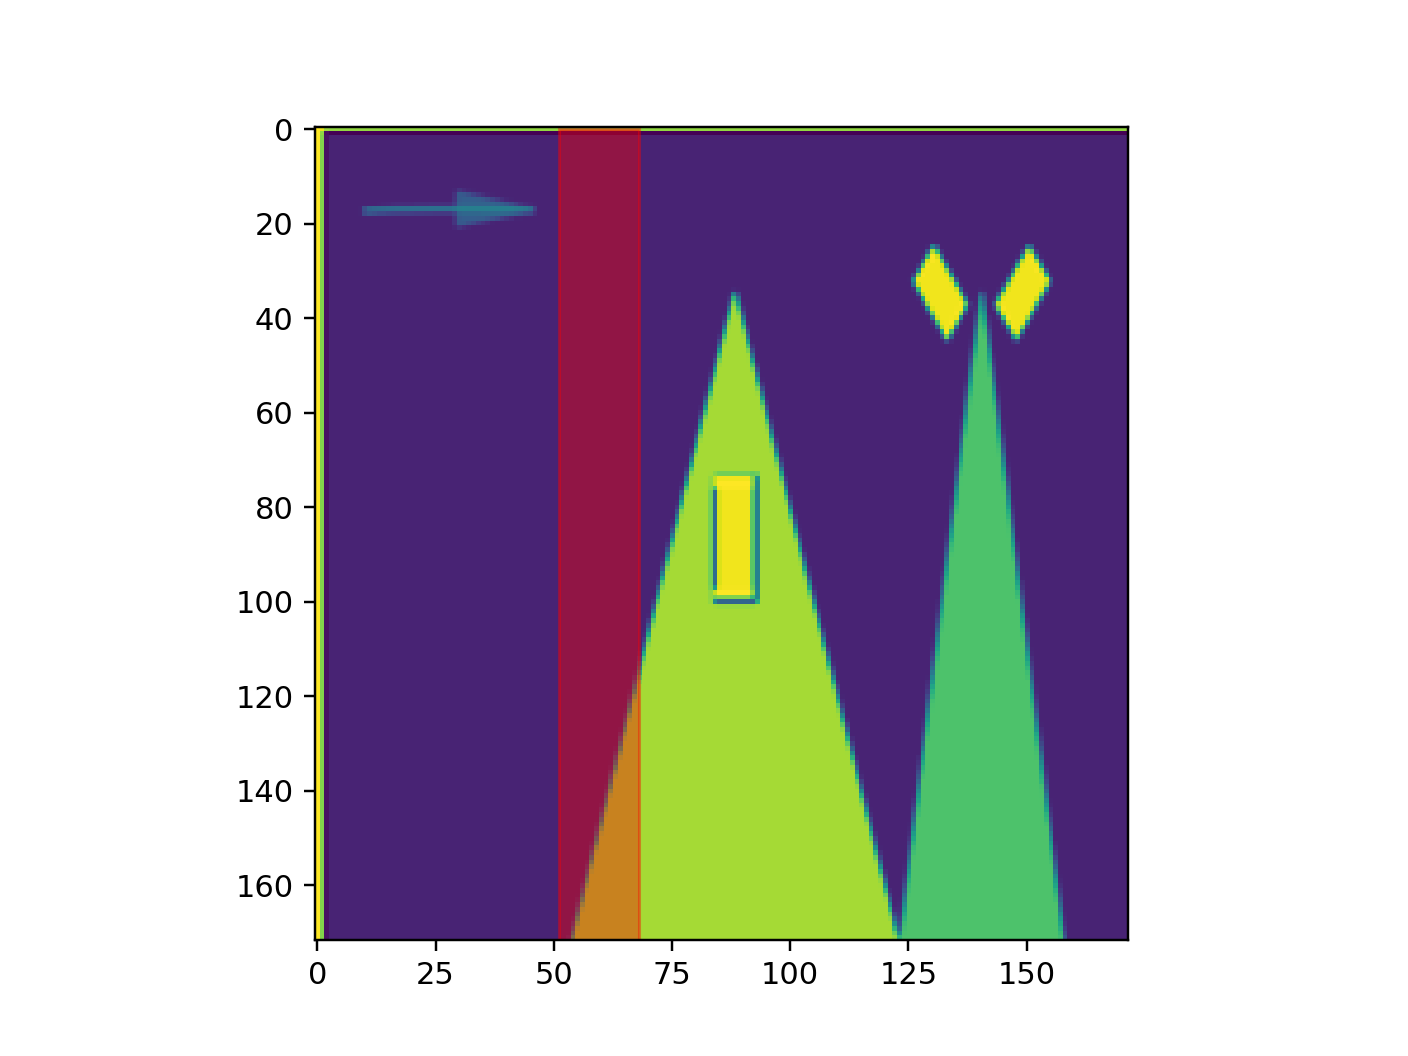

needle pose: tensor([2, 1, 5])


<IPython.core.display.Javascript object>


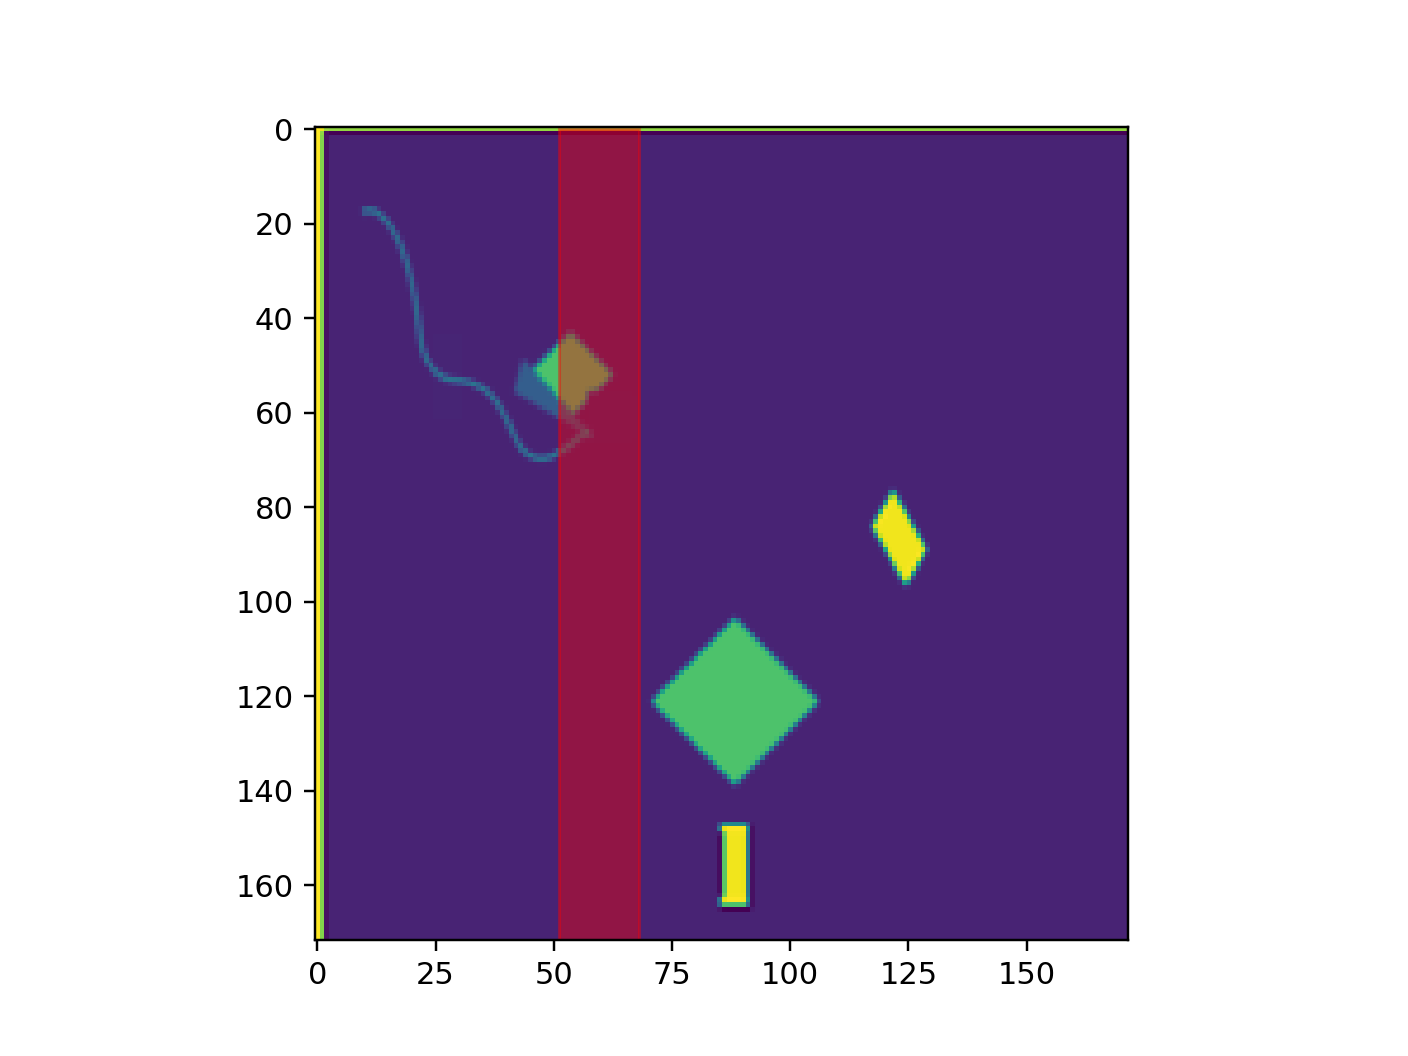

needle pose: tensor([3, 3, 5])


In [53]:
edge_size = 172

for dat in dataloader:
    outputs = model(dat['image'].to(DEVICE))
    prediction = outputs.cpu().detach().numpy()
    
    for idx in range(10):
        fig = plt.figure()
        im = dat['image'][idx,:, :, :].reshape(172, 172, 3)
        plt.imshow(dat['image'][idx,0, :, :])        
        
        if(MODE == 'regress'): # show where we predicted the needle to be 
            plt.scatter(dat['needle'][idx][0]*edge_size, dat['needle'][idx][1]*edge_size, c='r')
            plt.scatter(prediction[idx,0]*edge_size, prediction[idx,1]*edge_size, c='b')
            
        elif(MODE == 'classify'):
            class_pred = np.argmax(prediction[idx,:])
            
            shape = patches.Polygon([[np.int(np.floor(class_pred/10.0 * edge_size)), 0], \
                            [np.int(np.floor((class_pred+1)/10.0 * edge_size)), 0], \
                            [np.int(np.floor((class_pred+1)/10.0 * edge_size)), edge_size], 
                            [np.int(np.floor(class_pred/10.0 * edge_size)), edge_size]], color='r', alpha=0.4)
            plt.gca().add_patch(shape)
            
            
        plt.show()

        print('needle pose: ' + str(dat['needle'][idx]))

# About this notebook
Created on 2/13/2019. Original code from surgical_activity_recognition.py by Mike Peven. Modified by Molly O'Brien. 

# Footer 

In [ ]:
np.std(pred, axis=0)